# **Optimal Pricing for Carbon Efficient Flights**
## _A Machine Learning Approach to Modeling Carbon-Adjusted Airfare_

### Marco Gandola, Lennard Pische, Aram Bagdasarian, Vivek Shah


**Background and Motivation**

Airlines today face increasing pressure to reduce emissions while staying profitable. At the same time, travelers are becoming more conscious of their carbon footprint, yet it remains unclear whether lower emission flights are priced differently from other options once we account for distance, demand, and seasonality. Commercial aviation is responsible for roughly 2 to 3 percent of global CO₂ emissions, and the oligopolistic nature of the industry makes pricing strategies difficult to observe and understand.

The goal of this project is to quantify the relationship between airfare pricing and carbon intensity at the route-aircraft level, if any is found, and then build a prediction model for future flights to estimate average fares across routes.

**Problem statement**

Our problem is to understand **how fares vary with distance and carbon intensity at the route level**, holding constant key operational and firm-level factors such as carrier and aircraft type. In other words, we ask whether airlines appear to price greener flights differently after controlling for standard cost and market drivers. We also aim to use these insights to build a model that predicts future fares and evaluate how much additional predictive power emissions-related variables provide beyond standard features like distance and carrier.

**Data description**

We build a route-level dataset for U.S. domestic flights by combining two U.S. Department of Transportation sources:

- **DB1B Market**: a quarterly 10 percent sample of airline tickets. We aggregate tickets to the route level (year, origin airport, destination airport) and compute a **passenger-weighted average one-way fare** and an average great-circle distance for each route.
- **T-100 Domestic Segment**: flight-level operations data. We aggregate segments on the same route and year to obtain total **seats**, **reported passengers**, **payload**, **air time**, carrier, and aircraft type.

Using the T-100 aggregates, we construct **aircraft-specific emissions rates** in kg CO₂ per seat-kilometer by combining payload, air time, and seating capacity. These aircraft-level rates are then mapped back to the merged route data, which lets us compute for each route:

- distance in kilometers (`distance_km`)
- passenger-weighted average fare (`fare`)
- CO₂ per seat-kilometer (`co2_per_seat_km`)
- CO₂ per kilometer at the route level (`co2_per_km`)
- CO₂ per passenger-kilometer (`co2_per_pax_km`)

We also create categorical features:

- dummy variables for the **top 10 aircraft types** in the sample
- a binary `is_major_airline` indicator equal to 1 for AA, DL, UA, WN, AS, and B6, and 0 for all other carriers

**Initial hypothesis**

Our baseline hypothesis is that, after controlling for distance, carrier, and aircraft type, **more carbon-efficient flights are not obviously cheaper**. Airlines may partially pass operating cost savings through to passengers, but they might also price relatively greener flights at a premium or at similar levels, preferring to keep the margin rather than discount the fare. The empirical question is whether we see any systematic relationship between fare and CO₂ per passenger-kilometer once we condition on standard cost and firm controls.

**Research Questions**

Focusing on U.S. domestic flights, we ask:

- How do per-passenger CO₂ emissions vary across flights once we hold other predictors fixed, such as distance and aircraft type?

- On a given route, are lower emission flights priced differently from higher emission alternatives?

- How well can we predict route-level fares from distance, emissions, load factor, carrier, and aircraft type, and which variables matter most for prediction performance?

- If airlines moved toward more carbon-aligned pricing, how might that change airline and consumer behavior?


## Table of Contents

1. [Environment Setup & Data Loading](#setup)
2. [Baseline Model - Log-Log Regression with Fixed Effects](#bas)
3. [Baseline Model - Residual Analysis and Diagnostics](#bas-res)
4. [Advanced Model - Gradient Boosted Decision Tree Regression](#adv)
5. [Advanced Model - Residual Analysis and Diagnostics](#adv-res)
6. [Additional Specification - Generalized Additive Model](#209)
7. [Interpretation and Results](#int)



## 1. Environment Setup & Data Loading <a id="setup"></a>

This section includes the steps taken to preprocess data and formalize a preliminary visual analysis.

### Imports, Placeholders, and Paths

This section sets up the analysis environment and defines all global constants and file paths used throughout the project. We import the core libraries for data manipulation, visualization, modeling, and model evaluation. We then specify directory locations for the DB1B Market data, T100 segment data, and output plots, along with shared merge keys that uniquely identify a route. Finally, we define unit-conversion constants and a fallback CO₂-per-seat parameter used when aircraft-specific emissions data are unavailable.

In [1]:
# Libraries
from pathlib import Path
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import gaussian_kde
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# --- PATH CONFIGURATION ---
# Since we are in /notebooks, the root is one level up (..)
REPO_ROOT = Path("..").resolve() 
DATA_DIR = REPO_ROOT / "data"
PLOT_DIR = REPO_ROOT / "images"

# Create directories if they don't exist
PLOT_DIR.mkdir(exist_ok=True, parents=True)

# File Paths
DB1B_MARKET_PATH = DATA_DIR / "T_DB1B_MARKET.csv"
T100_PATH = DATA_DIR / "T_T100D_SEGMENT_US_CARRIER_ONLY.csv"

# Config
KEYS = ["year", "origin_airport_id", "dest_airport_id"]
MILES_TO_KM = 1.60934
SEAT_CO2_KG_PER_KM = 0.09

### Helper functions and Preliminary EDA

The code below defines all the helper functions we use to construct a clean route-level dataset and generate exploratory plots.

- `prep_db1b(market_path)` reads the DB1B MARKET file (fares and passengers), keeps only the columns we need, and aggregates to the route level (origin–destination–year) with passenger-weighted average fares and mean distances.
- `_mode(series)` is a small utility that returns the modal value of a `pandas.Series`, used when collapsing multiple segment observations to a single carrier or aircraft type.
- `prep_t100(path)` reads the T-100 segment data (seats, passengers, payload, airtime, carrier, aircraft type), constructs a quarter from the month, and aggregates to the same route-level keys as DB1B, keeping totals for seats, passengers, payload and air time, plus modal `carrier` and `aircraft_type`.
- `get_aircraft_co2_emissions(path)` computes an average CO₂ intensity per seat-km for each `AIRCRAFT_TYPE` using payload, seats, and air time, and returns a lookup dictionary. This is used as the emissions input to the main dataset.
- `enrich_features(df)` takes the merged DB1B–T100 routes and adds derived variables: distance in km, a clean `fare` variable, `co2_per_seat_km` (from the aircraft lookup with a fallback constant), total `co2_per_km`, and `co2_per_pax_km` where passenger counts are positive. It also creates dummy variables for the top 10 aircraft types and a flag for major U.S. carriers.
- `merge_data(save_excel=True)` calls `prep_db1b`, `prep_t100`, merges them on the common route keys (`KEYS`), applies `enrich_features`, prints basic information about the merged dataset, and (optionally) saves it as an Excel file in `DATA_DIR`.
- `summarize_metrics(df)` prints and returns descriptive statistics for the main continuous variables (`fare`, `distance_km`, `co2_per_km`, `passengers`), which we use as a quick sanity check before modeling.
- `save_and_show(fig, name)` is a small plotting helper that saves each figure to `PLOT_DIR` under a given filename and also displays it inline in the notebook.
- The plotting helpers `bar_missingness(df)`, `hist_plot(df, column, log=False)`, `kde_plot(df, column)`, `bar_top(df, column, top_n, title, slug)`, and `scatter_plot(df, x, y, slug)` provide reusable EDA tools to inspect missing values, marginal distributions, top carriers/aircraft, and relationships between key variables (e.g. fare vs distance or emissions).

Together, these functions take the raw DB1B and T-100 files in `DATA_DIR`, build a route-level panel with both pricing and emissions variables, and provide a small plotting toolkit that we can call in later cells when we describe the EDA results.



In [2]:
import sys
sys.path.append('../src')
from utils import (
    prep_db1b, prep_t100, enrich_features, merge_data, # Data Prep
    summarize_metrics, bar_missingness, hist_plot, kde_plot, bar_top, scatter_plot, save_and_show # Visualization
)

Here, we first construct the final analysis dataset by calling `merge_data(save_excel=False)`, which merges the DB1B Market fare data with T-100 operational data at the route level and enriches it with distance and CO₂-related features. The resulting `merged_df` contains one observation per route with pricing, traffic, aircraft, carrier, and emissions variables.

Next, we call `summarize_metrics(merged_df)` to report basic descriptive statistics for the main continuous variables—fare, distance, CO₂ emissions, and passenger counts.









In [3]:
merged_df = merge_data(save_excel=False)
summarize_metrics(merged_df)

Loading DB1B...
Loading T100...
Merging datasets...
Merged rows: 13,512
Metric summary:
                count          mean            std       min         25%  \
fare         13512.0    251.129517      98.273306   0.00000  197.971225   
distance_km  13512.0   1668.291839    1051.203401  49.88954  953.313778   
co2_per_km   13512.0  14820.208033  146475.331504   0.00000   39.923979   
passengers   13512.0    916.130847    2085.461315   1.00000   35.000000   

                     50%           75%           max  
fare          252.809895    297.524553  2.156070e+03  
distance_km  1455.419310   2095.141877  1.330012e+04  
co2_per_km   1185.742174  10847.912306  1.611203e+07  
passengers    210.000000    741.000000  2.704100e+04  


,count,mean,std,min,25%,50%,75%,max
fare,13512.0,251.129517,98.273306,0.00000,197.971225,252.809895,297.524553,2.156070e+03
distance_km,13512.0,1668.291839,1051.203401,49.88954,953.313778,1455.419310,2095.141877,1.330012e+04
co2_per_km,13512.0,14820.208033,146475.331504,0.00000,39.923979,1185.742174,10847.912306,1.611203e+07
passengers,13512.0,916.130847,2085.461315,1.00000,35.000000,210.000000,741.000000,2.704100e+04



The merged dataset contains **13,512** route–quarter observations for Q1 2025, combining DB1B Market fare data with T-100 operational and aircraft information. Each observation represents a unique origin–destination pair with associated fares, passenger volumes, aircraft usage, and constructed CO₂ emissions measures.

Fares average USD 251, with a median of USD 253, indicating a roughly symmetric central distribution but with slightly pronounced right-tail outliers (with the maximum being above $2,100). Route distances are highly variable: the median distance is about 1,455 km, while the longest routes exceed 13,000 km, reflecting the inclusion of both short-haul domestic and long-haul international segments.

CO2 emissions per kilometer, on the other hand, show substantial dispersion. While the median CO2 per km is relatively modest ( about 1,185), the mean is much higher (about 14,820) due to extreme values, likely driven by high-capacity/wide-body aircraft, dense routes, or aggregation effects in the T-100 data. The presence of zeros at the minimum highlights routes where emissions could not be reliably constructed (this motivates some of our subsequent filtering before the construction of our log-based model).

Passenger volumes are also highly skewed: the typical route carries a few hundred passengers per quarter (median 210), but others carry many more.


### Visual Analysis

What follows is a series of visual analysis conducted on the feature we are going to later analyze when constructing the models. We start by calling `bar_missingness` to verify the presence of missing values (NaNs) in our data.



Saved plot -> /Users/lennypische/Desktop/docs/OptimalCarbonPricing/images/missingness.png


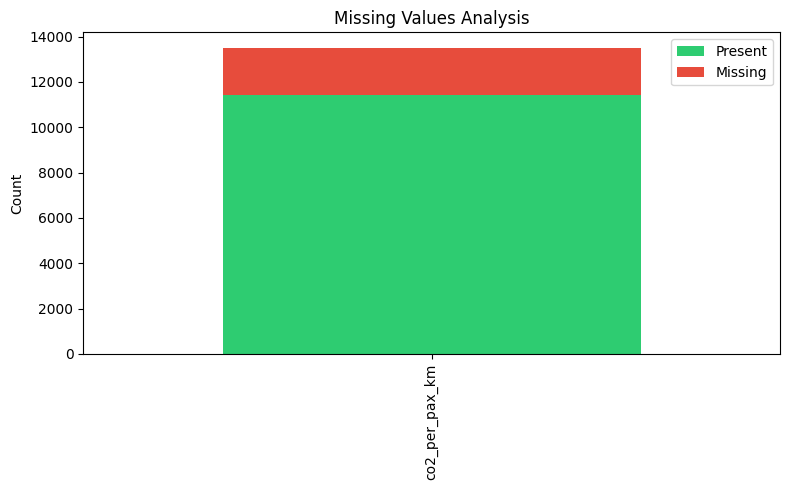

The number of missing observations in co2_per_pax_km is:  {2076}


In [4]:
bar_missingness(merged_df)
print(f'The number of missing observations in co2_per_pax_km is: ', {int(merged_df['co2_per_pax_km'].isna().sum())})

This missingness plot shows that all non-trivial missing values are concentrated in `co2_per_pax_km`, with 1324 observations having missing values in this variable. All other variables are essentially complete after merging DB1B Market and T-100 data.

This pattern is structural rather than random. In our construction, `co2_per_pax_km` is defined as total aircraft CO2 per kilometer divided by reported passengers. Missing values arise when:

- reported_passengers is zero or missing in the T-100 data, or

- aircraft type–specific emissions cannot be reliably computed (after filtering on seats, payload, or air time).

Importantly, these missing values do not indicate data quality issues in fare or distance variables, but instead reflect limitations in constructing per-passenger emissions for a subset of low-traffic or irregular routes. For later modeling, we could either

- drop these observations in log-log regressions involving emissions, or

- create missingness indicator or use prediction-based imputation of values (preferred approach).

Next, we use `hist_plot` to visualize the distribution of airfares contained in the dataset.

Saved plot -> /Users/lennypische/Desktop/docs/OptimalCarbonPricing/images/hist_fare.png


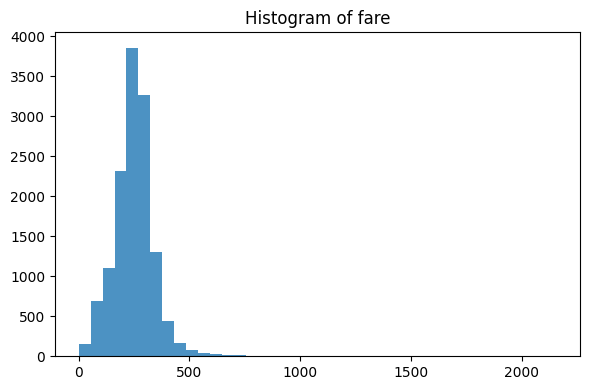

Saved plot -> /Users/lennypische/Desktop/docs/OptimalCarbonPricing/images/hist_log_fare.png


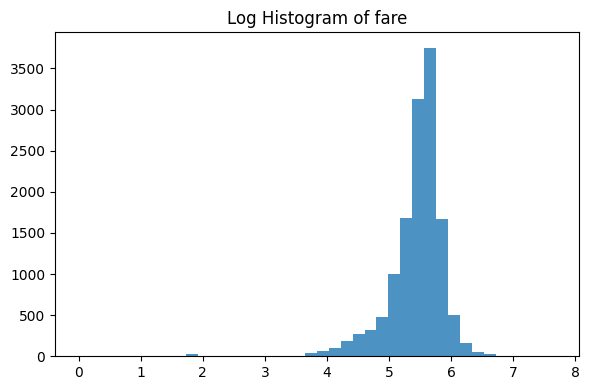

In [5]:
# Raw fare
hist_plot(merged_df, "fare")

# Log fare
hist_plot(merged_df, "fare", log=True)

The fare distribution is strongly right-skewed, with most average route fares clustered between roughly  USD 150 and  USD 350, and a long right tail extending beyond $1,000. This pattern is consistent with typical airline pricing, where the majority of routes operate in a competitive mid-price range, while a small number of routes—often longer, less competitive, or constrained by limited service—exhibit very high average fares.

Next, we use `hist_plot` and `kde_plot` to visualize the distribution of route distances and the density of CO2 emitted, per passenger, per km.

Saved plot -> /Users/lennypische/Desktop/docs/OptimalCarbonPricing/images/hist_distance_km.png


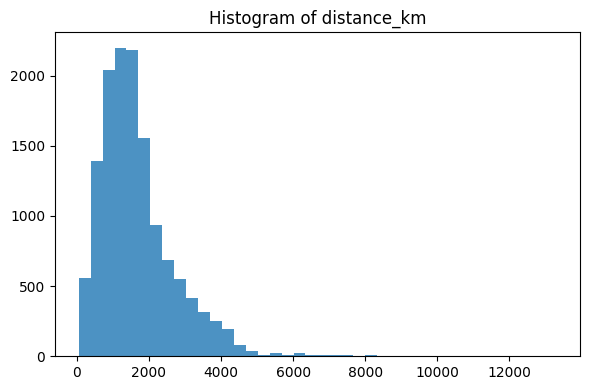

Saved plot -> /Users/lennypische/Desktop/docs/OptimalCarbonPricing/images/kde_log_co2_per_pax_km.png


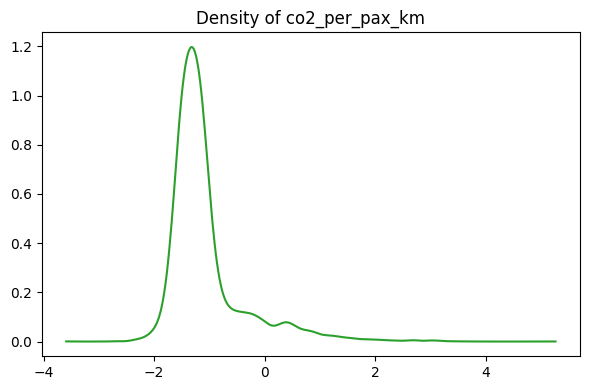

In [6]:
hist_plot(merged_df, "distance_km")
kde_plot(merged_df, "co2_per_pax_km", log=True)

The first plot shows the distribution of route distances in kilometers. The distribution is heavily right-skewed, with most routes falling below 2,000 km and a long tail corresponding to long-haul flights.

The KDE plot shows the kernel density of log CO2 emissions per passenger-kilometer. The distribution is tightly clustered (at around -1.5 =  exp(1.5) ≈ `0.22 kg CO2 / km / passenger` with a long right tail, reflecting standardized aircraft efficiency across most routes and a small number of low-load or short-haul flights with disproportionately high emissions intensity.

Together, these motivate a log-log pricing model that interprets regression coefficients as elasticities.

Next, we analyze the distributions of the 10 top carriers and aircraft types through `bar_top`.

Saved plot -> /Users/lennypische/Desktop/docs/OptimalCarbonPricing/images/top_carriers.png


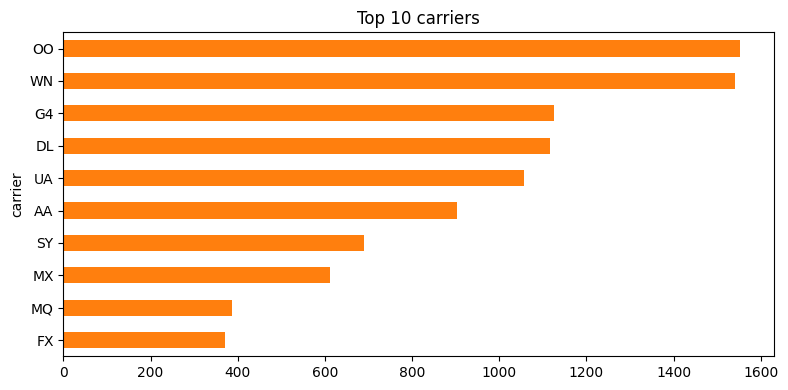

Saved plot -> /Users/lennypische/Desktop/docs/OptimalCarbonPricing/images/top_aircraft.png


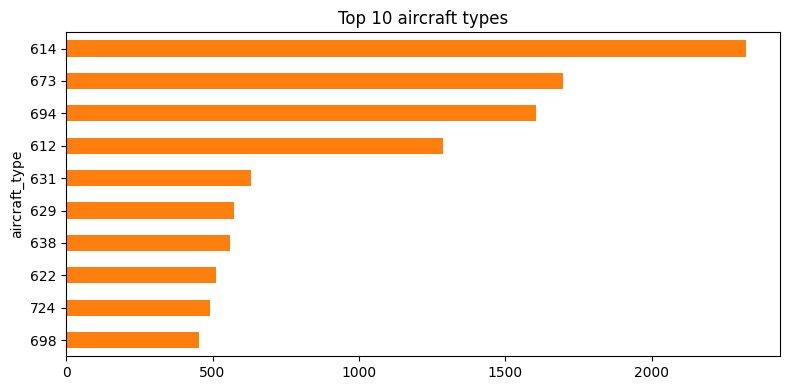

In [7]:
bar_top(merged_df, "carrier", 10, "Top 10 carriers", "top_carriers")
bar_top(merged_df, "aircraft_type", 10, "Top 10 aircraft types", "top_aircraft")

The carrier composition plot shows a highly concentrated distribution of observations across a small number of airlines. Regional and high-frequency operators [most notably SkyWest (OO) and Southwest (WN)] account for a large share of route-quarter observations, while legacy carriers such as American (AA), Delta (DL), and United (UA) appear less frequently. This pattern reflects operational structure rather than market dominance. In fact, in the aviation industry, regional carriers operate many short-haul routes with high frequency, so this is what generates more observations in route-based datasets like DB1B or T100. Additionally, legacy carriers often outsource regional routes to these smaller carriers, who then report the flights as operated by them. As a result, the presence of a carrier in the data reflects how often it flies routes, not how many passengers it carries or its pricing power.

The aircraft-type distribution is similarly concentrated, with a small set of narrow-body and regional jets dominating the sample. Aircraft such as the Boeing 737-800 (614), Airbus A320-200 (694), and Embraer ERJ-175 (673) account for most observations, while a long tail of less frequent aircraft types contributes relatively little. The sharp drop-off beyond the most common types suggests that emissions, distance, and fare patterns in the data will be driven primarily by these aircraft families rather than by rare or specialized models.

For our next visualization, we use `scatter_plot` to analyze the relationship between key indicators of distance, fares, and CO2 emissions.

Saved plot -> /Users/lennypische/Desktop/docs/OptimalCarbonPricing/images/scatter_distance_fare.png


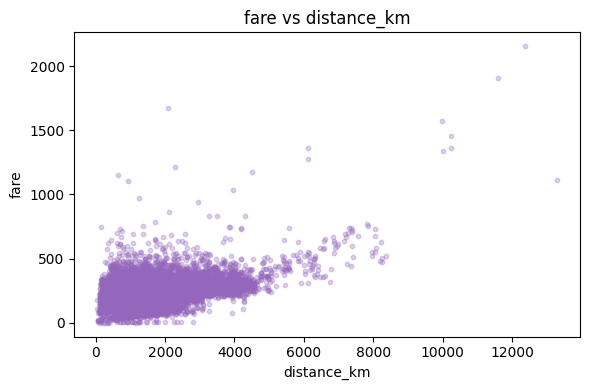

Saved plot -> /Users/lennypische/Desktop/docs/OptimalCarbonPricing/images/scatter_distance_co2_per_pax.png


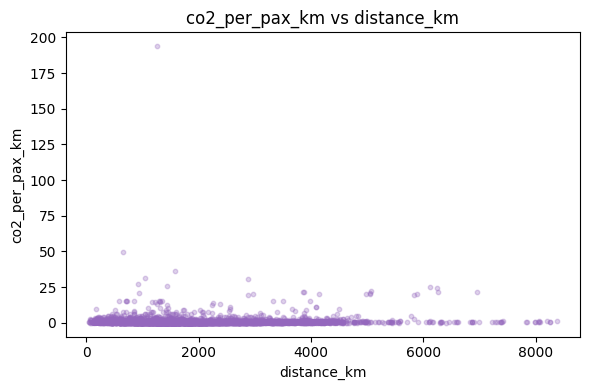

Saved plot -> /Users/lennypische/Desktop/docs/OptimalCarbonPricing/images/scatter_co2_fare.png


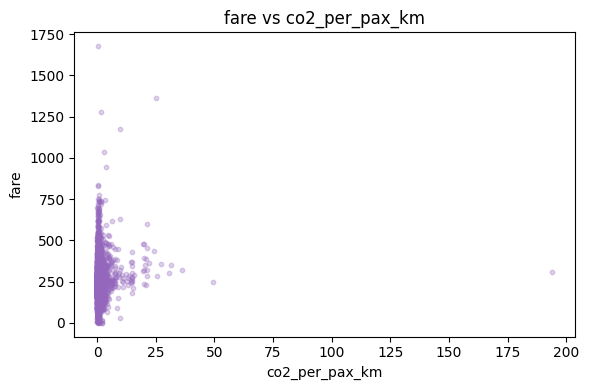

In [8]:
# Fare vs distance
scatter_plot(merged_df, "distance_km", "fare", "distance_fare")

# CO₂ per pax-km vs distance
scatter_plot(merged_df, "distance_km", "co2_per_pax_km", "distance_co2_per_pax")

# Fare vs CO₂ per pax-km
scatter_plot(merged_df, "co2_per_pax_km", "fare", "co2_fare")

The fare vs. distance plot shows a clear positive relationship: longer routes tend to have higher fares on average, though the relationship is far from linear. There is substantial dispersion at shorter and medium distances, reflecting heterogeneity in competition, route density, and carrier pricing strategies. At long distances, fares rise but remain noisy, with a few extreme high-fare outliers likely corresponding to thin international or niche markets. This result is intuitive: the lengthier the flight, the pricier the route, though competitive considerations are starting to reverse this trend (as observable in the graph, some of the longer fights, on average, cost approximately the same as the shorter routes).

The CO2 per passenger-km vs. distance plot exhibits a different pattern: emissions intensity is generally higher and more variable on short routes, then compresses toward lower values as distance increases. This is consistent with aviation physics, since takeoff and climb are carbon-intensive phases that are amortized over longer distances, making long-haul flights more efficient per kilometer on a per-passenger basis.

The fare vs. CO2 per passenger-km plot reveals a weak but non-random association. Most observations cluster at low CO2 intensity levels, with fares spanning a wide range, suggesting that emissions efficiency alone does not determine ticket prices. However, the highest CO2-per-passenger-km observations tend to exhibit higher fares and greater dispersion. This pattern hints that emissions intensity may be correlated with market frictions (such as limited competition or small aircraft usage) rather than directly priced carbon costs.

Overall, taken together, the plots motivate a multivariate framework, shown in the next sections: distance strongly shapes both fares and emissions, while emissions intensity may still carry incremental explanatory power for fares after controlling for route length and fixed effects.

## 2. Baseline Model - Log-Log Regularized Linear Regression with Fixed Effects <a id="bas"></a>

This baseline model serves two purposes. First, it establishes a transparent benchmark linking airfares to fundamental cost drivers (route length and emissions intensity) before introducing moving to a more flexible machine learning approach later in the notebook.

Distance captures scale and operational cost effects (fuel burn, crew time, aircraft utilization), while CO2 per passenger-kilometer proxies for aircraft efficiency and load factors, two key determinants of marginal operating costs that are not directly observable in fare data.

Second, incorporating carrier and aircraft fixed effects allows us to separate pricing differences driven by technology and firm-level strategies from those driven by route characteristics.

We start with a log–log linear regression framework with ridge (L2) regularization and enforce a train–test split. The following is an overview of the technical specifications modeled in the notebook.

- The function `fit_regularized_loglog_model` estimates a baseline log–log pricing model in which the dependent variable is the logarithm of average route fare (`log_fare`), and the primary explanatory variables are the logarithm of route distance (`log_distance_km`) and the logarithm of CO2 emissions per passenger-kilometer (`log_co2_per_pax_km`). The log–log specification allows estimated coefficients to be interpreted as elasticities, which is particularly appropriate given the heavily right-skewed distributions of fares, distances, and emissions. To mitigate overfitting arising from the large number of fixed-effect dummies, the model is estimated via ridge (L2) regularization.

- The function first filters the data to economically meaningful observations (strictly positive fares, distances, and emissions intensity) and dropping rows with missing carrier or aircraft information (we will handle missingness less naively in our advanced model). It then constructs carrier fixed effects via one-hot encoding of the carrier variable (dropping the reference category) and aircraft fixed effects using pre-computed dummy variables for the top 10 most common aircraft types.

- Finally, the function performs an explicit `train_test_split` (80/20) using the appropriate `sklearn` function, and fits a ridge-regularized linear model on the training set only. The regularization parameter is selected via 5-fold cross-validation over a logarithmic grid of candidate values. The function returns the fitted model and the training and testing design matrices.

Mathematically, this corresponds to fitting the following log–log linear regression model:

$$
\log(\text{fare}_{iq})
= \beta_0
+ \beta_1 \log(\text{distance}_{iq})
+ \beta_2 \log(\text{CO}_2\text{ per pax-km}_{iq})
+ \gamma_{c(i)}
+ \delta_{a(i)}
+ \varepsilon_{iq},
$$

where $i$ indexes route–quarter observations, $\gamma_{c(i)}$ are carrier fixed effects, $\delta_{a(i)}$ are aircraft-type fixed effects, and $\varepsilon_{iq}$ is the error term. Importantly, $log$ is the natural logarithm function in accordance to standard statistical notation.

The coefficients are estimated by minimizing the penalized least squares objective:
$$
\sum_i \left(\log(\text{fare}_i) - x_i^\top \beta \right)^2
+
\lambda \lVert \beta \rVert_2^2,
$$
where $\lambda \ge 0$ is a ridge penalty parameter selected via cross-validation on the training data.


In [9]:
def fit_regularized_loglog_model(df: pd.DataFrame, test_size: float = 0.2, random_state: int = 1090,
                                 alphas=None):
    """
    Log–log pricing model with carrier and aircraft fixed effects,
    estimated via Ridge regression (L2 regularization).

    Returns:
        model      : fitted sklearn Pipeline (StandardScaler + RidgeCV)
        X_train    : training design matrix (no intercept column)
        X_test     : test design matrix
        y_train    : training response
        y_test     : test response
    """
    df = df.copy()

    # Keep valid observations: need positive fare, distance, and CO2 per pax-km
    df = df[
        (df["fare"] > 0) &
        (df["distance_km"] > 0) &
        (df["co2_per_pax_km"] > 0)
    ].dropna(subset=["carrier", "aircraft_type", "co2_per_pax_km"])

    # Log transformations
    df["log_fare"] = np.log(df["fare"])
    df["log_distance_km"] = np.log(df["distance_km"])
    df["log_co2_per_pax_km"] = np.log(df["co2_per_pax_km"])

    # === Fixed effects ===
    # Carrier fixed effects (one-hot, drop first)
    carrier_dummies = pd.get_dummies(
        df["carrier"], prefix="carrier", drop_first=True
    )

    # Aircraft fixed effects: already-created top-10 dummy columns
    aircraft_fe_cols = [c for c in df.columns if c.startswith("aircraft_type_")]
    aircraft_dummies = df[aircraft_fe_cols]

    # Design matrix: distance elasticity + emissions elasticity + fixed effects
    X = pd.concat(
        [
            df[["log_distance_km", "log_co2_per_pax_km"]],
            carrier_dummies,
            aircraft_dummies,
        ],
        axis=1,
    )

    # Response
    y = df["log_fare"]

    # Make sure everything is numeric
    X = X.apply(pd.to_numeric, errors="coerce")
    y = pd.to_numeric(y, errors="coerce")

    # Drop any rows where X or y is NaN
    valid_mask = X.notna().all(axis=1) & y.notna()
    X = X.loc[valid_mask]
    y = y.loc[valid_mask]

    # === Train/test split ===
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # === RidgeCV with standardization ===
    if alphas is None:
        # Reasonable grid over several orders of magnitude
        alphas = np.logspace(-4, 4, 20)

    ridge_pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("ridge", RidgeCV(alphas=alphas, cv=5))
    ])

    ridge_pipeline.fit(X_train, y_train)

    return ridge_pipeline, X_train, X_test, y_train, y_test

Next, we fit the ridge-regularized log–log model on the training set and report a summary of its estimated coefficients, the cross-validated penalty parameter, and the model’s explanatory power on both the training and test samples.

In [10]:
baseline_model, X_train, X_test, y_train, y_test = fit_regularized_loglog_model(merged_df)

def summarize_regularized_loglog(model, X_train, y_train, y_test, X_test):
    """
    Print key information for the regularized log–log model:
    chosen alpha, intercept, top coefficients, and simple performance metrics.
    """
    # Extract the inner Ridge model
    ridge = model.named_steps["ridge"]
    scaler = model.named_steps["scaler"]

    feature_names = X_train.columns
    coefs = ridge.coef_

    coef_df = pd.DataFrame({
        "feature": feature_names,
        "coef": coefs
    }).sort_values("coef", key=lambda s: s.abs(), ascending=False)

    print(f"Chosen alpha (λ): {ridge.alpha_:.4f}")
    print(f"Intercept (on original log_fare scale): {ridge.intercept_:.4f}\n")

    print("Top 15 coefficients by absolute value:")
    display(coef_df.head(15))

    # Performance metrics
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)

    print("\nPerformance:")
    print(f"Train R^2: {train_r2:.3f}")
    print(f"Test  R^2: {test_r2:.3f}")

summarize_regularized_loglog(baseline_model, X_train, y_train, y_test, X_test)


Chosen alpha (λ): 78.4760
Intercept (on original log_fare scale): 5.4099

Top 15 coefficients by absolute value:


,feature,coef
0,log_distance_km,0.164702
31,carrier_G4,-0.148144
59,carrier_XP,-0.082949
71,aircraft_type_724,-0.062274
26,carrier_DL,0.046230
29,carrier_F9,-0.040636
46,carrier_NK,-0.039734
43,carrier_MQ,0.038184
19,carrier_AA,0.037526
53,carrier_SY,0.036436



Performance:
Train R^2: 0.431
Test  R^2: 0.378


#### Interpretation of Baseline Model

The ridge-regularized log–log model explains a meaningful share of variation in route-level airfares, achieving a training $R^2$ of $0.43$ and an out-of-sample $R^2$ of $0.38$. The relatively small gap between in-sample and test performance suggests that regularization successfully controls overfitting arising from the large set of carrier and aircraft fixed effects, yielding a stable and defensible baseline model.

The estimated distance elasticity of fares is positive but well below one: a 1% increase in route distance is associated with approximately a $0.16%$ increase in fares, holding emissions intensity and fixed effects constant. While longer routes entail higher absolute operating costs, economies of scale, such as more efficient cruise phases and fixed costs spread over longer distances, reduce the responsiveness of fares to distance.

The elasticity with respect to emissions intensity, measured by $\log(\text{CO}_2)$ per passenger-kilometer, is also positive but small (≈ 0.03). This indicates that more emissions-intensive operations tend to be associated with slightly higher fares, which is consistent with the idea that operational inefficiency raise marginal costs. However, the small magnitude suggests that emissions intensity plays a secondary role in pricing relative to distance and firm- or aircraft-specific factors.

Carrier fixed effects exhibit substantial cross-airline heterogeneity, even after regularization. Several low-cost and ultra-low-cost carriers (e.g., NK, F9, G4, SY) display large negative coefficients relative to the omitted baseline carrier, reflecting systematically lower fare strategies that persist after controlling for route length, emissions intensity, and aircraft type. On the other hand, certain network and regional carriers show positive fare premium, consistent with differences in service models, market power, or network positioning.

Aircraft fixed effects are present but generally smaller in magnitude than carrier effects, which indicates that aircraft technology influences fares primarily through its interaction with carrier strategies rather than as a standalone determinant. The shrinkage induced by ridge regularization suggests that many aircraft-specific effects are noisy once carrier and route fundamentals are accounted for.

The regularized log–log model performs well as an interpretable benchmark, but its moderate explanatory power and linear structure motivate the transition to the gradient-boosted decision tree model introduced next, which is better suited to capturing nonlinear pricing relationships and higher-order interactions that are difficult to model parametrically.

To gain a better understanding of the model performance, we now manually compute the `MSE` and `RMSE`. We use these metrics because they directly measure how far predicted values are from observed outcomes in a way that is both statistically meaningful and easy to interpret. Squaring the errors penalizes large mistakes more heavily than small ones, which is particularly important in airfare data where large pricing errors are meaningful.

In [11]:
# Predictions
y_train_pred_log = baseline_model.predict(X_train)
y_test_pred_log = baseline_model.predict(X_test)
residuals = y_test - y_test_pred_log

# MSE and RMSE
mse_train_log = mean_squared_error(y_train, y_train_pred_log)
rmse_train_log = np.sqrt(mse_train_log)

mse_test_log = mean_squared_error(y_test, y_test_pred_log)
rmse_test_log = np.sqrt(mse_test_log)

print(f"Train log-MSE:  {mse_train_log:.4f}")
print(f"Train log-RMSE: {rmse_train_log:.4f}")
print(f"Test log-MSE:   {mse_test_log:.4f}")
print(f"Test log-RMSE:  {rmse_test_log:.4f}")

Train log-MSE:  0.1159
Train log-RMSE: 0.3405
Test log-MSE:   0.1209
Test log-RMSE:  0.3477


The baseline regularized log–log regression achieves very similar performance on the training and test sets. On the training data, the model attains a log-MSE of $0.116$ and a log-RMSE of $0.341$, while on the test data the log-MSE is $0.121$ with a log-RMSE of $0.348$. The closeness of training and test errors suggests that the model generalizes reasonably well and is not strongly overfitting, even with the inclusion of carrier and aircraft fixed effects.

Because the model is estimated in log space, a log-RMSE of roughly 0.35 corresponds to typical multiplicative prediction errors of about 35–40% in fares. In other words, the predicted fare for a given route is usually within a factor of $e^{0.35} \approx 1.42$ of the observed fare. While this error level is not small, it is consistent with the high variability of airfare prices, where the data reflect dynamic revenue-management algorithms and competitive forces that are often proprietary and difficult to model.

Overall, these results indicate that while the baseline model captures broad structural relationships between fares, distance, emissions, and fixed carrier/aircraft effects, there remains meaningful unexplained variation. What follows, then, is a deep-dive into a diagnostic analysis of the residuals and how the model could be improved.

## 3. Baseline Model - Residual Analysis and Diagnostics <a id="bas-res"></a>

We start by visualizing the distribution of model residuals, defined as the difference between observed log-fares and the model’s predicted log-fares.

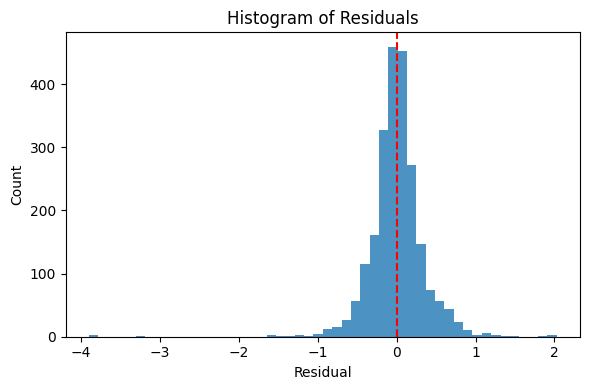

In [12]:
plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=50, alpha=0.8)
plt.axvline(0, color="red", linestyle="--")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.title("Histogram of Residuals")
plt.tight_layout()
plt.show()

From the visual analysis of the plot, we observe that residuals are tightly centered around zero, which indicates that on average the model does not systematically over- or under-predict log-fares.

At the same time, the distribution is not perfectly symmetric: there is a visible left tail extending below −1, meaning the model occasionally over-predicts fares by a substantial margin for some routes (i.e., predicted > actual). A smaller right tail indicates occasional under-prediction as well.

Next, we examine a scatter plot of residuals as a function of CO2 emissions per passenger-kilometer, plotted in levels with a logarithmic x-axis.

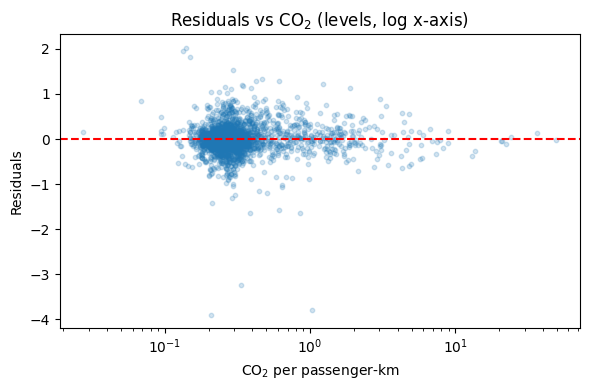

In [13]:
plt.figure(figsize=(6, 4))
plt.scatter(
    np.exp(X_test["log_co2_per_pax_km"]),
    residuals,
    alpha=0.2,
    s=10
)
plt.axhline(0, color="red", linestyle="--")
plt.xscale("log")
plt.xlabel("CO$_2$ per passenger-km")
plt.ylabel("Residuals")
plt.title("Residuals vs CO$_2$ (levels, log x-axis)")
plt.tight_layout()
plt.show()


Here, residuals are broadly centered around zero across the emissions range, indicating no strong systematic over- or under-prediction tied directly to CO₂ intensity. This supports our idea that including log(co2_per_pax_km) captures a meaningful average relationship with fares.

Two features stand out:

- First, dispersion is largest at low CO2 values, where points are more spread out vertically, suggesting greater pricing variability for very efficient flights, and again disproving our initial hypothesis that airlines will price low-CO2 emission flights less.

- Second, as CO2 per passenger-km increases, the residual cloud tightens and becomes more symmetric around zero, implying more stable predictions in higher-emissions regimes. A few extreme negative outliers remain, consistent with heterogeneous route- or fare-driven pricing that the linear specification cannot fully capture, reinforcing the case for a more flexible model later on in the notebook.

We end the baseline diagnostic section by visualizing the distribution of residuals for the top carriers and aircraft types in the dataset.

<Figure size 1000x400 with 0 Axes>

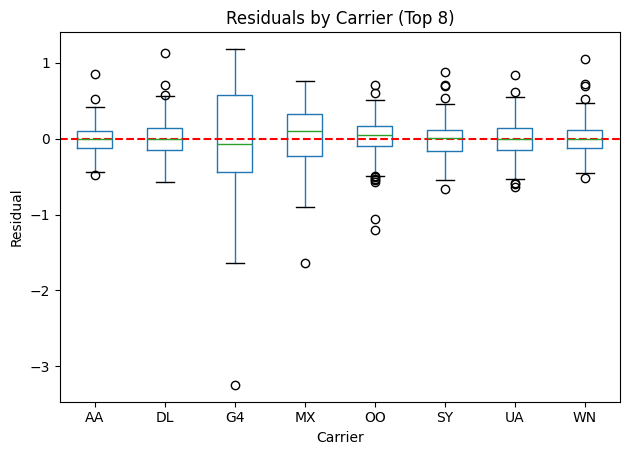

In [14]:
df_resid = merged_df.loc[X_test.index].copy()
df_resid["residual"] = (y_test - y_test_pred_log).values

top_carriers = df_resid["carrier"].value_counts().head(8).index

plt.figure(figsize=(10, 4))
df_resid[df_resid["carrier"].isin(top_carriers)].boxplot(
    column="residual",
    by="carrier",
    grid=False,
)
plt.axhline(0, color="red", linestyle="--")
plt.title("Residuals by Carrier (Top 8)")
plt.suptitle("")
plt.xlabel("Carrier")
plt.ylabel("Residual")
plt.tight_layout()
plt.show()

Overall, residuals for all carriers are centered close to zero, indicating that the baseline log–log model does not systematically over- or under-predict fares for any single major carrier on average. Legacy and low-cost carriers alike (e.g., AA, DL, UA, WN) show medians very near zero, suggesting that carrier fixed effects capture much of the mean pricing differences across airlines.

However, there are notable differences in dispersion and tail behavior. Some carriers (most visibly G4 - Allegiant Air - and MX - Breeze Airways) exhibit wider interquartile ranges and more extreme negative outliers, which indicates greater pricing variability or (more likely, due to their low-cost and regional nature) sporadic deep discounts that the linear specification does not fully explain. Others (such as AA - American Airlines - and SY - Sun Country Airlines) display tighter distributions, implying more predictable pricing around the model’s fitted values.

<Figure size 1000x400 with 0 Axes>

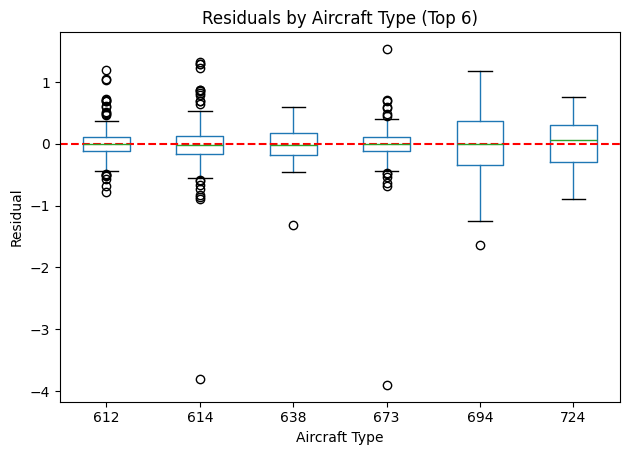

In [15]:
top_aircraft = df_resid["aircraft_type"].value_counts().head(6).index

plt.figure(figsize=(10, 4))
df_resid[df_resid["aircraft_type"].isin(top_aircraft)].boxplot(
    column="residual",
    by="aircraft_type",
    grid=False,
)
plt.axhline(0, color="red", linestyle="--")
plt.title("Residuals by Aircraft Type (Top 6)")
plt.suptitle("")
plt.xlabel("Aircraft Type")
plt.ylabel("Residual")
plt.tight_layout()
plt.show()

Overall, most aircraft types have median residuals close to zero, which suggests that the baseline log–log model is broadly well-calibrated across aircraft categories and does not systematically over- or under-predict fares for a single dominant type. Aircraft types 612 (B737-700), 614 (B737-800), 638 (CRJ-900), and 673 (ERJ-175) show relatively tight interquartile ranges clustered near zero, indicating that for these common narrow-body and regional jets, the model performs fairly consistently.

However, there are meaningful differences in dispersion across aircraft types. Aircraft 694 (A320) and 724 (A220-300) exhibit noticeably wider spreads and more extreme outliers, which suggests higher unexplained variation even after controlling for distance, emissions, and carrier fixed effects.

The above analysis signals the need for a more flexible model that can capture nonlinear interactions between our model features, which is our next step.


## 4. Advanced Model - Gradient Boosted Decision Tree Regression <a id="adv"></a>

### Model motivation

The log-log linear model with fixed effects is easy to interpret and it provides a clean estimate of elasticities, but it imposes strong structure: fares respond linearly in log space to distance and CO₂, and all carrier or aircraft effects enter as simple level shifts. In practice, pricing can be highly non-linear and may involve interactions between distance, cabin size, load factor, and carrier identity.

To relax these assumptions, we estimate a **Gradient Boosted Decision Tree (GBDT) model** that predicts `log_fare` using a richer set of features. Tree-based models naturally capture non-linearities and high-order interactions and tend to work well on tabular data.

### Features and preprocessing

For the GBDT we:

- restrict to observations with positive fare and distance
- build the target as `log_fare`
- include continuous features such as `distance_km`, `co2_per_pax_km`, `co2_per_seat_km`, `co2_per_km`, `passengers`, `reported_passengers`, `seats`, `payload`, and `air_time`
- construct derived features:
  - **load factor** = reported_passengers / seats  
  - **passenger density** = passengers / distance_km  
  - **speed proxy** = air_time / distance_km  
  - **distance_squared** and a **co2_distance_interaction**
- add the `is_major_airline` dummy, aircraft-type dummies, and a numeric encoding of `carrier`

Because `co2_per_pax_km` is missing in a non-trivial share of routes, we use a **prediction-based imputation step**: a Random Forest regressor fitted on rows with non-missing CO₂ predicts the missing values, and we keep a `co2_per_pax_km_was_missing` indicator to allow the model to treat imputed rows differently.

### Estimation strategy

We split the data into training and test sets using the same split as the baseline model. On the training data, we run a **RandomizedSearchCV** over the main hyperparameters of `GradientBoostingRegressor` (number of trees, depth, learning rate, subsample, and minimum leaf size) with 5-fold cross-validation and negative mean squared error as the objective.

The best combination of hyperparameters from cross-validation is then used to fit a final model on the full training set. We evaluate this model on the held-out test set and compare its test RMSE and R² in log space to the baseline log-log regression.

### Feature importance

We summarize the fitted model using the **feature importance** scores exposed by the GBDT. The bar chart for the top 20 features highlights which variables matter most for predicting log fares in this non-linear setting. In particular, we can see whether:

- distance remains the dominant driver once we allow for non-linear interactions
- CO₂-related variables (per seat, per passenger, or per kilometer) carry additional predictive power beyond distance and capacity
- carrier or aircraft-type indicators play a major role in explaining residual variation in fares

The following illustrates a representative decision tree from the gradient-boosted model, highlighting how simple threshold splits partition the feature space and generate locally constant predictions.


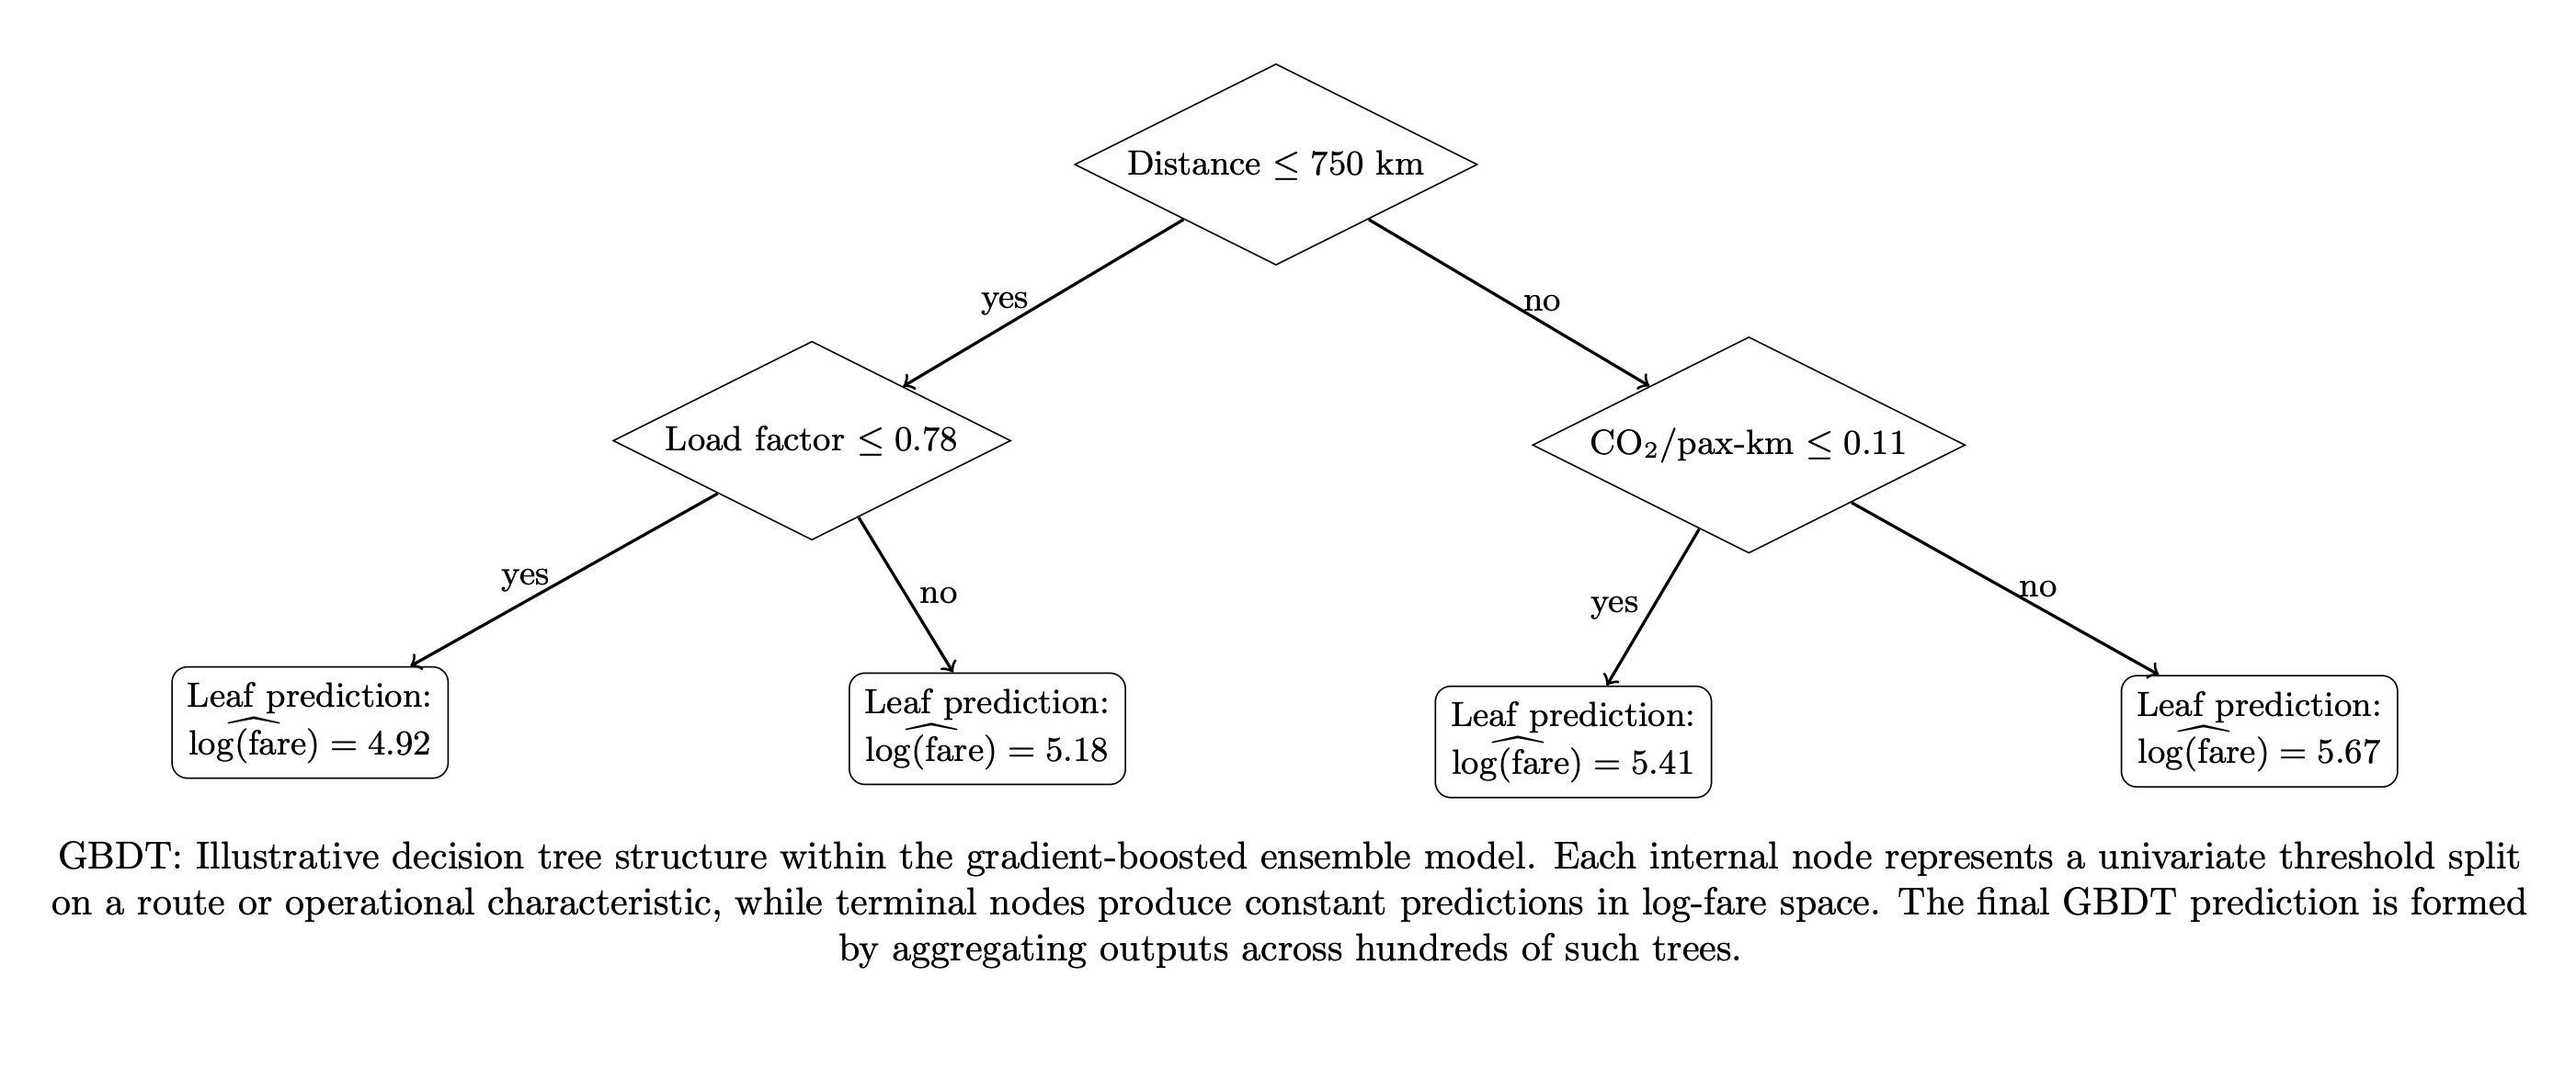

### Additional imports for GBDT model

As mentioned above, use ensemble-based regression models, including Random Forests and Gradient Boosting, to capture nonlinear relationships and feature interactions. Missing values are handled using prediction-based imputation, and categorical variables are encoded numerically where needed. Model performance is evaluated using cross-validation, and hyperparameters are tuned efficiently via randomized search over predefined distributions. We additionally consider `XGBoost`, a regularized and highly optimized gradient boosting framework well-suited for tabular data. The following imports are necessary for performing these steps.

In [16]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from scipy.stats import randint, uniform
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

### Missingness

We start by imputing missing values of `co2_per_pax_km` using a prediction-based approach. A Random Forest regressor is trained on observations with complete emissions data, leveraging flight characteristics, aircraft dummies, airline indicators, and passenger-related variables. Missing entries are then predicted using this model, with remaining feature-level missingness handled via median imputation. A missingness indicator is added to preserve information about originally missing observations.

In [17]:
def impute_co2_per_pax_km(df: pd.DataFrame) -> pd.DataFrame:
    """
    Impute missing co2_per_pax_km using prediction-based imputation.
    Uses Random Forest to predict missing values based on other features.
    """
    df = df.copy()

    complete_mask = df["co2_per_pax_km"].notna()
    missing_mask = df["co2_per_pax_km"].isna()

    if missing_mask.sum() == 0:
        print("No missing values to impute.")
        return df

    print(f"Imputing {missing_mask.sum():,} missing values using prediction-based imputation...")


    imputation_features = [
        "distance_km",
        "seats",
        "payload",
        "air_time",
        "co2_per_seat_km",
        "co2_per_km",
        "passengers",
        "reported_passengers",
        "is_major_airline"
    ]


    aircraft_dummy_cols = [c for c in df.columns if c.startswith("aircraft_type_")]
    imputation_features.extend(aircraft_dummy_cols)


    if "carrier" in df.columns:
        df["carrier_encoded"] = pd.Categorical(df["carrier"]).codes
        imputation_features.append("carrier_encoded")

    # Prepare data
    X_complete = df.loc[complete_mask, imputation_features].copy()
    y_complete = df.loc[complete_mask, "co2_per_pax_km"].copy()
    X_missing = df.loc[missing_mask, imputation_features].copy()


    X_complete = X_complete.fillna(X_complete.median())
    X_missing = X_missing.fillna(X_complete.median())  # Use training median

    # Train Random Forest for imputation
    imputation_model = RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        random_state=1090,
        n_jobs=-1
    )
    imputation_model.fit(X_complete, y_complete)

    # Predict missing values
    imputed_values = imputation_model.predict(X_missing)
    df.loc[missing_mask, "co2_per_pax_km"] = imputed_values


    df["co2_per_pax_km_was_missing"] = missing_mask.astype(int)

    print(f"Imputation complete. Mean imputed value: {imputed_values.mean():.4f}")
    print(f"Mean original value: {y_complete.mean():.4f}")

    return df

### Model Features

Next, we construct the feature matrix for the GBDT model by filtering valid flights, log-transforming fares, and combining raw operational variables with engineered features capturing efficiency, scale, and nonlinear effects (e.g., load factor, passenger density, distance squared, and CO₂–distance interactions). Airline, aircraft, and temporal controls are included where available, along with missingness indicators. Remaining missing values are handled via median imputation.

In [18]:
def prepare_gbdt_features(df: pd.DataFrame) -> tuple[pd.DataFrame, pd.Series]:
    """
    Prepare features and target for GBDT model.
    Returns X (features) and y (target: log_fare).
    """
    df = df.copy()

    df = df[
        (df["fare"] > 0) &
        (df["distance_km"] > 0)
    ].copy()


    df["log_fare"] = np.log(df["fare"])


    features_list = []


    continuous_features = [
        "distance_km",
        "co2_per_pax_km",
        "co2_per_seat_km",
        "co2_per_km",
        "passengers",
        "reported_passengers",
        "seats",
        "payload",
        "air_time"
    ]
    features_list.extend(continuous_features)


    df["load_factor"] = df["reported_passengers"] / df["seats"].replace(0, np.nan)
    df["passenger_density"] = df["passengers"] / df["distance_km"].replace(0, np.nan)
    df["speed_proxy"] = df["air_time"] / df["distance_km"].replace(0, np.nan)
    df["distance_squared"] = df["distance_km"] ** 2

    derived_features = [
        "load_factor",
        "passenger_density",
        "speed_proxy",
        "distance_squared"
    ]
    features_list.extend(derived_features)

    # Interaction features
    df["co2_distance_interaction"] = df["co2_per_pax_km"] * df["distance_km"]
    features_list.append("co2_distance_interaction")

    # Missingness indicator
    if "co2_per_pax_km_was_missing" in df.columns:
        features_list.append("co2_per_pax_km_was_missing")


    if "is_major_airline" in df.columns:
        features_list.append("is_major_airline")

    aircraft_dummy_cols = [c for c in df.columns if c.startswith("aircraft_type_")]
    features_list.extend(aircraft_dummy_cols)


    if "carrier" in df.columns:
        df["carrier_encoded"] = pd.Categorical(df["carrier"]).codes
        features_list.append("carrier_encoded")

    if "year" in df.columns:
        features_list.append("year")

    # Build feature matrix
    X = df[features_list].copy()
    X = X.fillna(X.median())
    y = df["log_fare"].copy()


    valid_idx = y.notna()
    X = X.loc[valid_idx]
    y = y.loc[valid_idx]

    print(f"Feature matrix shape: {X.shape}")
    print(f"Features used: {len(features_list)}")

    return X, y

### Model Specification

Here, the function `fit_advanced_gbdt_model` trains a Gradient Boosted Decision Tree model to predict log fares using structured flight and emissions data. It optionally imputes missing CO₂-per-passenger values, constructs features, and splits the data into training and test sets. Model hyperparameters are tuned via randomized search with 5-fold cross-validation to minimize mean squared error. The best-performing model is then evaluated on both the training and test sets using RMSE and R² (in log space), and feature importances along with predictions, performance metrics, and cross-validation results are returned for analysis.


In [19]:

def fit_advanced_gbdt_model(
    df: pd.DataFrame,
    test_size: float = 0.2,
    random_state: int = 1090,
    use_imputation: bool = True,
    n_iter: int = 50
) -> dict:
    """
    Fit Gradient Boosted Decision Tree model with cross-validated hyperparameter tuning.
    Uses scikit-learn's GradientBoostingRegressor (no XGBoost dependency).

    Returns:
        Dictionary with model, predictions, metrics, feature importance, etc.
    """
    df = df.copy()

    # Impute missing co2_per_pax_km
    if use_imputation:
        df = impute_co2_per_pax_km(df)
    else:
        df = df.dropna(subset=["co2_per_pax_km"])
        df["co2_per_pax_km_was_missing"] = 0

    # Prepare features
    X, y = prepare_gbdt_features(df)

    # Train/test split (same as baseline)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    print(f"\nTraining set size: {len(X_train):,}")
    print(f"Test set size: {len(X_test):,}")

    # Define hyperparameter search space for GradientBoostingRegressor
    param_distributions = {
        'n_estimators': [100, 200, 300, 500],
        'max_depth': [3, 4, 5, 6, 7],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None]
    }

    # Create base model
    base_model = GradientBoostingRegressor(
        random_state=random_state,
        loss='squared_error'
    )

    print("\nStarting hyperparameter tuning with 5-fold CV...")
    random_search = RandomizedSearchCV(
        estimator=base_model,
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        random_state=random_state,
        verbose=1
    )

    # Fit on training data
    random_search.fit(X_train, y_train)

    print(f"\nBest parameters found:")
    for param, value in random_search.best_params_.items():
        print(f"  {param}: {value}")
    print(f"Best CV score (negative MSE): {random_search.best_score_:.4f}")
    print(f"Best CV RMSE: {np.sqrt(-random_search.best_score_):.4f}")

    # Step 7: Train final model with best parameters on full training set
    best_model = random_search.best_estimator_

    # Step 8: Evaluate on test set
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    # Metrics in log space
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_r2 = best_model.score(X_train, y_train)
    test_r2 = best_model.score(X_test, y_test)

    print(f"\n=== Model Performance ===")
    print(f"Train RMSE (log): {train_rmse:.4f}")
    print(f"Test RMSE (log):  {test_rmse:.4f}")
    print(f"Train R²:         {train_r2:.4f}")
    print(f"Test R²:          {test_r2:.4f}")

    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)

    return {
        'model': best_model,
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'y_train_pred': y_train_pred,
        'y_test_pred': y_test_pred,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'feature_importance': feature_importance,
        'best_params': random_search.best_params_,
        'cv_results': random_search.cv_results_
    }

### Model Visualization

Lastly, we define `plot_feature_importance`, a  function that visualizes feature importance from the trained Gradient Boosting model. It selects the top `N` most influential features based on the model’s importance scores and displays them in a horizontal bar chart, allowing for easy interpretation of which variables contribute most to the model’s predictions.

In [20]:
def plot_feature_importance(results: dict, top_n: int = 20):
    """Plot top N most important features."""
    importance_df = results['feature_importance'].head(top_n)

    fig, ax = plt.subplots(figsize=(10, 6))
    importance_df.sort_values('importance').plot(
        x='feature', y='importance', kind='barh', ax=ax, color='#2ca02c'
    )
    ax.set_xlabel('Feature Importance')
    ax.set_title(f'Top {top_n} Most Important Features (Gradient Boosting)')
    plt.tight_layout()
    save_and_show(fig, 'gbdt_feature_importance')

### Fit

We are now ready to fit the advanced gradient boosted decision tree model using imputed CO2-per-passenger values and cross-validated hyperparameter tuning. We then visualize the top 20 most important features from the trained model to interpret the primary drivers of predicted airfares.

Imputing 2,076 missing values using prediction-based imputation...
Imputation complete. Mean imputed value: 23.7432
Mean original value: 0.5624
Feature matrix shape: (13506, 28)
Features used: 28

Training set size: 10,804
Test set size: 2,702

Starting hyperparameter tuning with 5-fold CV...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best parameters found:
  subsample: 0.9
  n_estimators: 500
  min_samples_split: 2
  min_samples_leaf: 1
  max_features: log2
  max_depth: 5
  learning_rate: 0.1
Best CV score (negative MSE): -0.0933
Best CV RMSE: 0.3054

=== Model Performance ===
Train RMSE (log): 0.1441
Test RMSE (log):  0.2812
Train R²:         0.9025
Test R²:          0.6004
Saved plot -> /Users/lennypische/Desktop/docs/OptimalCarbonPricing/images/gbdt_feature_importance.png


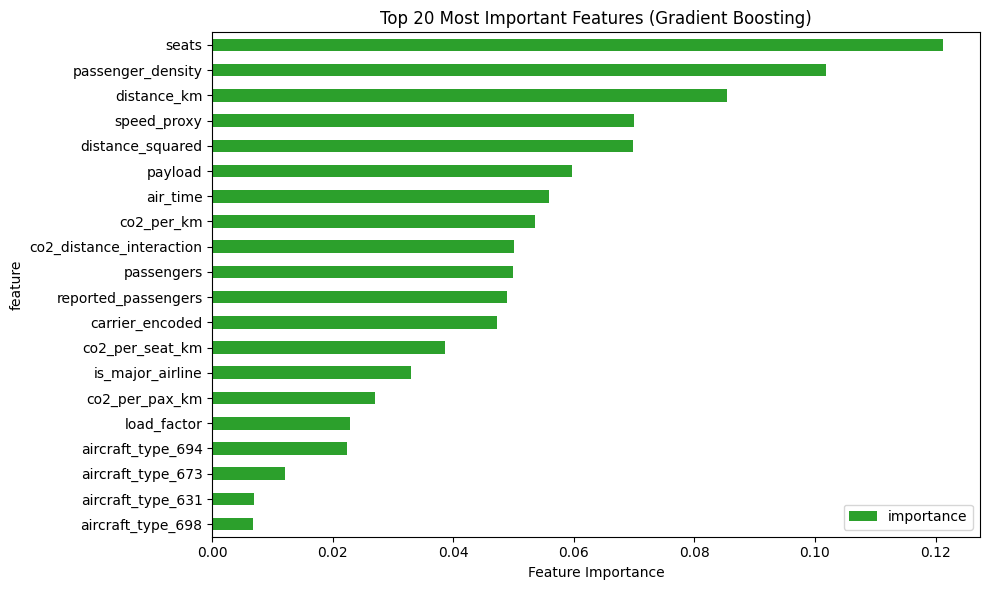

In [21]:
# Fit the advanced model
results = fit_advanced_gbdt_model(
    merged_df,
    use_imputation=True,
    n_iter=50
)

# Plot feature importance
plot_feature_importance(results, top_n=20)

### Interpretation

The feature importance plot shows that the GBDT leans most heavily on basic capacity and distance variables. **Seats** is the single most important predictor, followed by **passenger_density**, **air_time**, **distance_squared**, and **distance_km**. Together, these features capture how long the route is and how much capacity is available and used on that route.

**Carrier_encoded** also has high importance, which means that fare levels vary a lot by carrier even after we control for distance and aircraft characteristics. In the same spirit, **speed_proxy** (air_time divided by distance) and **passengers** help the model pick up differences in how flights are operated and how full they are.

Emissions related variables appear in the middle of the ranking. The **co2_distance_interaction**, **co2_per_pax_km**, **co2_per_km**, and **co2_per_seat_km** features all have non zero importance, which shows that carbon intensity does help refine predictions. However, they are clearly secondary to the core distance and capacity measures rather than the main drivers of fare variation.

Several other operational variables play a supporting role. **is_major_airline**, **payload**, **load_factor**, and **reported_passengers** all carry some weight, which is consistent with the idea that both who flies the route and how full and heavy the aircraft is matter for pricing.

Finally, a few specific aircraft type indicators (**aircraft_type_694**, **aircraft_type_698**, **aircraft_type_673**, and **aircraft_type_631**) have smaller but positive importance. These dummies allow the model to adjust fares for particular aircraft that tend to be systematically more or less expensive to operate.

Overall, the importance profile suggests that the GBDT sees fares primarily as a function of route length, capacity, and carrier identity, with emissions and aircraft specific effects adding extra, but more modest, predictive power.


## 5. Advanced Model - Residual Analysis and Diagnostics <a id="adv-res"></a>

Number of test observations: 2,702
Residual mean (should be near 0): -0.0056
Saved plot -> /Users/lennypische/Desktop/docs/OptimalCarbonPricing/images/gbdt_residual_histogram.png


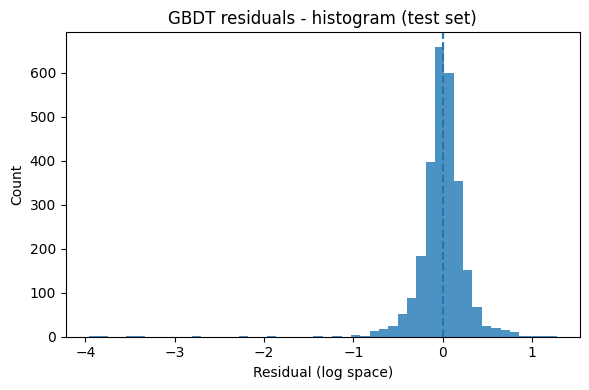

Saved plot -> /Users/lennypische/Desktop/docs/OptimalCarbonPricing/images/gbdt_residuals_vs_fitted.png


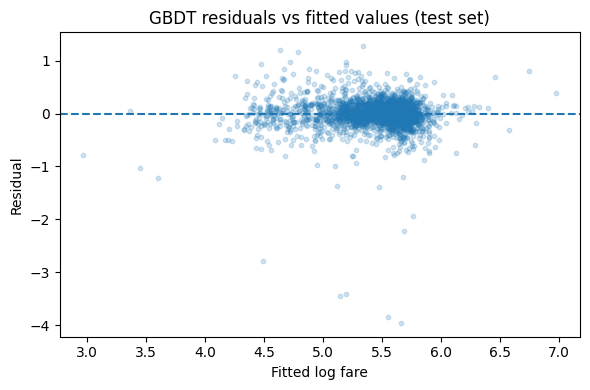

Saved plot -> /Users/lennypische/Desktop/docs/OptimalCarbonPricing/images/gbdt_residuals_vs_distance.png


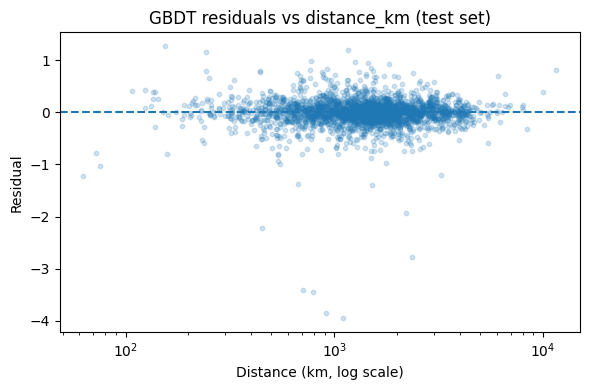

In [22]:
# Advanced model residual diagnostics on the test set

# Unpack results
gbdt_model = results["model"]
X_train_gbdt = results["X_train"]
X_test_gbdt = results["X_test"]
y_train_gbdt = results["y_train"]
y_test_gbdt = results["y_test"]
y_train_pred_gbdt = results["y_train_pred"]
y_test_pred_gbdt = results["y_test_pred"]

# Residuals in log space
gbdt_resid = y_test_gbdt - y_test_pred_gbdt
gbdt_fitted = y_test_pred_gbdt

print(f"Number of test observations: {len(y_test_gbdt):,}")
print(f"Residual mean (should be near 0): {gbdt_resid.mean():.4f}")

# 1. Histogram of residuals
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(gbdt_resid, bins=50, alpha=0.8)
ax.axvline(0, linestyle="--")
ax.set_xlabel("Residual (log space)")
ax.set_ylabel("Count")
ax.set_title("GBDT residuals - histogram (test set)")
plt.tight_layout()
save_and_show(fig, "gbdt_residual_histogram")

# 2. Residuals vs fitted values
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(gbdt_fitted, gbdt_resid, alpha=0.2, s=10)
ax.axhline(0, linestyle="--")
ax.set_xlabel("Fitted log fare")
ax.set_ylabel("Residual")
ax.set_title("GBDT residuals vs fitted values (test set)")
plt.tight_layout()
save_and_show(fig, "gbdt_residuals_vs_fitted")

# 3. Residuals vs distance (match by index in merged_df)
gbdt_test_idx = X_test_gbdt.index
df_gbdt_resid = merged_df.loc[gbdt_test_idx].copy()
df_gbdt_resid["residual_gbdt"] = gbdt_resid.values

fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(
    df_gbdt_resid["distance_km"],
    df_gbdt_resid["residual_gbdt"],
    alpha=0.2,
    s=10
)
ax.axhline(0, linestyle="--")
ax.set_xscale("log")
ax.set_xlabel("Distance (km, log scale)")
ax.set_ylabel("Residual")
ax.set_title("GBDT residuals vs distance_km (test set)")
plt.tight_layout()
save_and_show(fig, "gbdt_residuals_vs_distance")


The GBDT residual histogram on the test set is tightly centered near zero, with the bulk of residuals between about −0.5 and 0.5 in log space. There are a few large negative residuals and a thin right tail, but these outliers are relatively rare. This pattern is consistent with a model that is generally well calibrated in log space with only occasional large errors.

The residuals versus fitted values show a dense cloud around zero across the full range of predicted log fares. Most points lie in a narrow horizontal band, and we do not see a strong curve or clear funnel shape. This suggests that the GBDT is not systematically over or under predicting for cheap versus expensive routes, and there is no obvious remaining non linear pattern that the model is missing.

When we plot residuals against distance on a log scale, residuals remain centered close to zero at both short and long stage lengths. The spread is fairly similar across distances, with just a handful of extreme negative outliers. There is no clear tendency for the model to consistently overpredict or underpredict fares for very short hops or very long flights. Overall, these diagnostics support the idea that the GBDT is capturing the main structure in the data and that the remaining errors mostly look like random noise rather than being driven by simple distance related misspecification.

## 6. Additional Specification - Generalized Additive Model (GAM) <a id="209"></a>

### Model motivation

The Generalized Additive Model (GAM) maintains an additive structure that preserves interpretability while allowing each continuous predictor to have its own smooth, non-linear function estimated via penalized regression splines. This semi-parametric approach is particularly well-suited for our airfare prediction problem because it can reveal non-linear patterns in relationships For example, we can aswer how the effect of distance on fares may vary across different distance ranges due to economies of stage length. The model still allows us to understand the contribution of each predictor independently.

### Features and preprocessing

For the GAM we:

- restrict to observations with positive fare and distance
- build the target as `log_fare`
- include continuous features: `distance_km`, `co2_per_pax_km`, `seats`, and `load_factor` (constructed as reported_passengers / seats)
- include categorical features: `carrier`, `aircraft_type`, and `is_major_airline`

Because `co2_per_pax_km` is missing in a non-trivial share of routes, we use the same prediction-based imputation step as in the GBDT model – a Random Forest regressor fitted on rows with non-missing CO₂ predicts the missing values, preserving all observations for analysis.

We split the data into training and test sets using the same split as the baseline model (random_state=1090, test_size=0.2). The GAM is specified with smooth spline terms for continuous variables and factor terms for categorical variables. The number of spline basis functions (n_splines) is set to balance flexibility and generalization: 10 for distance (the most important predictor) and 8 for the other continuous variables.

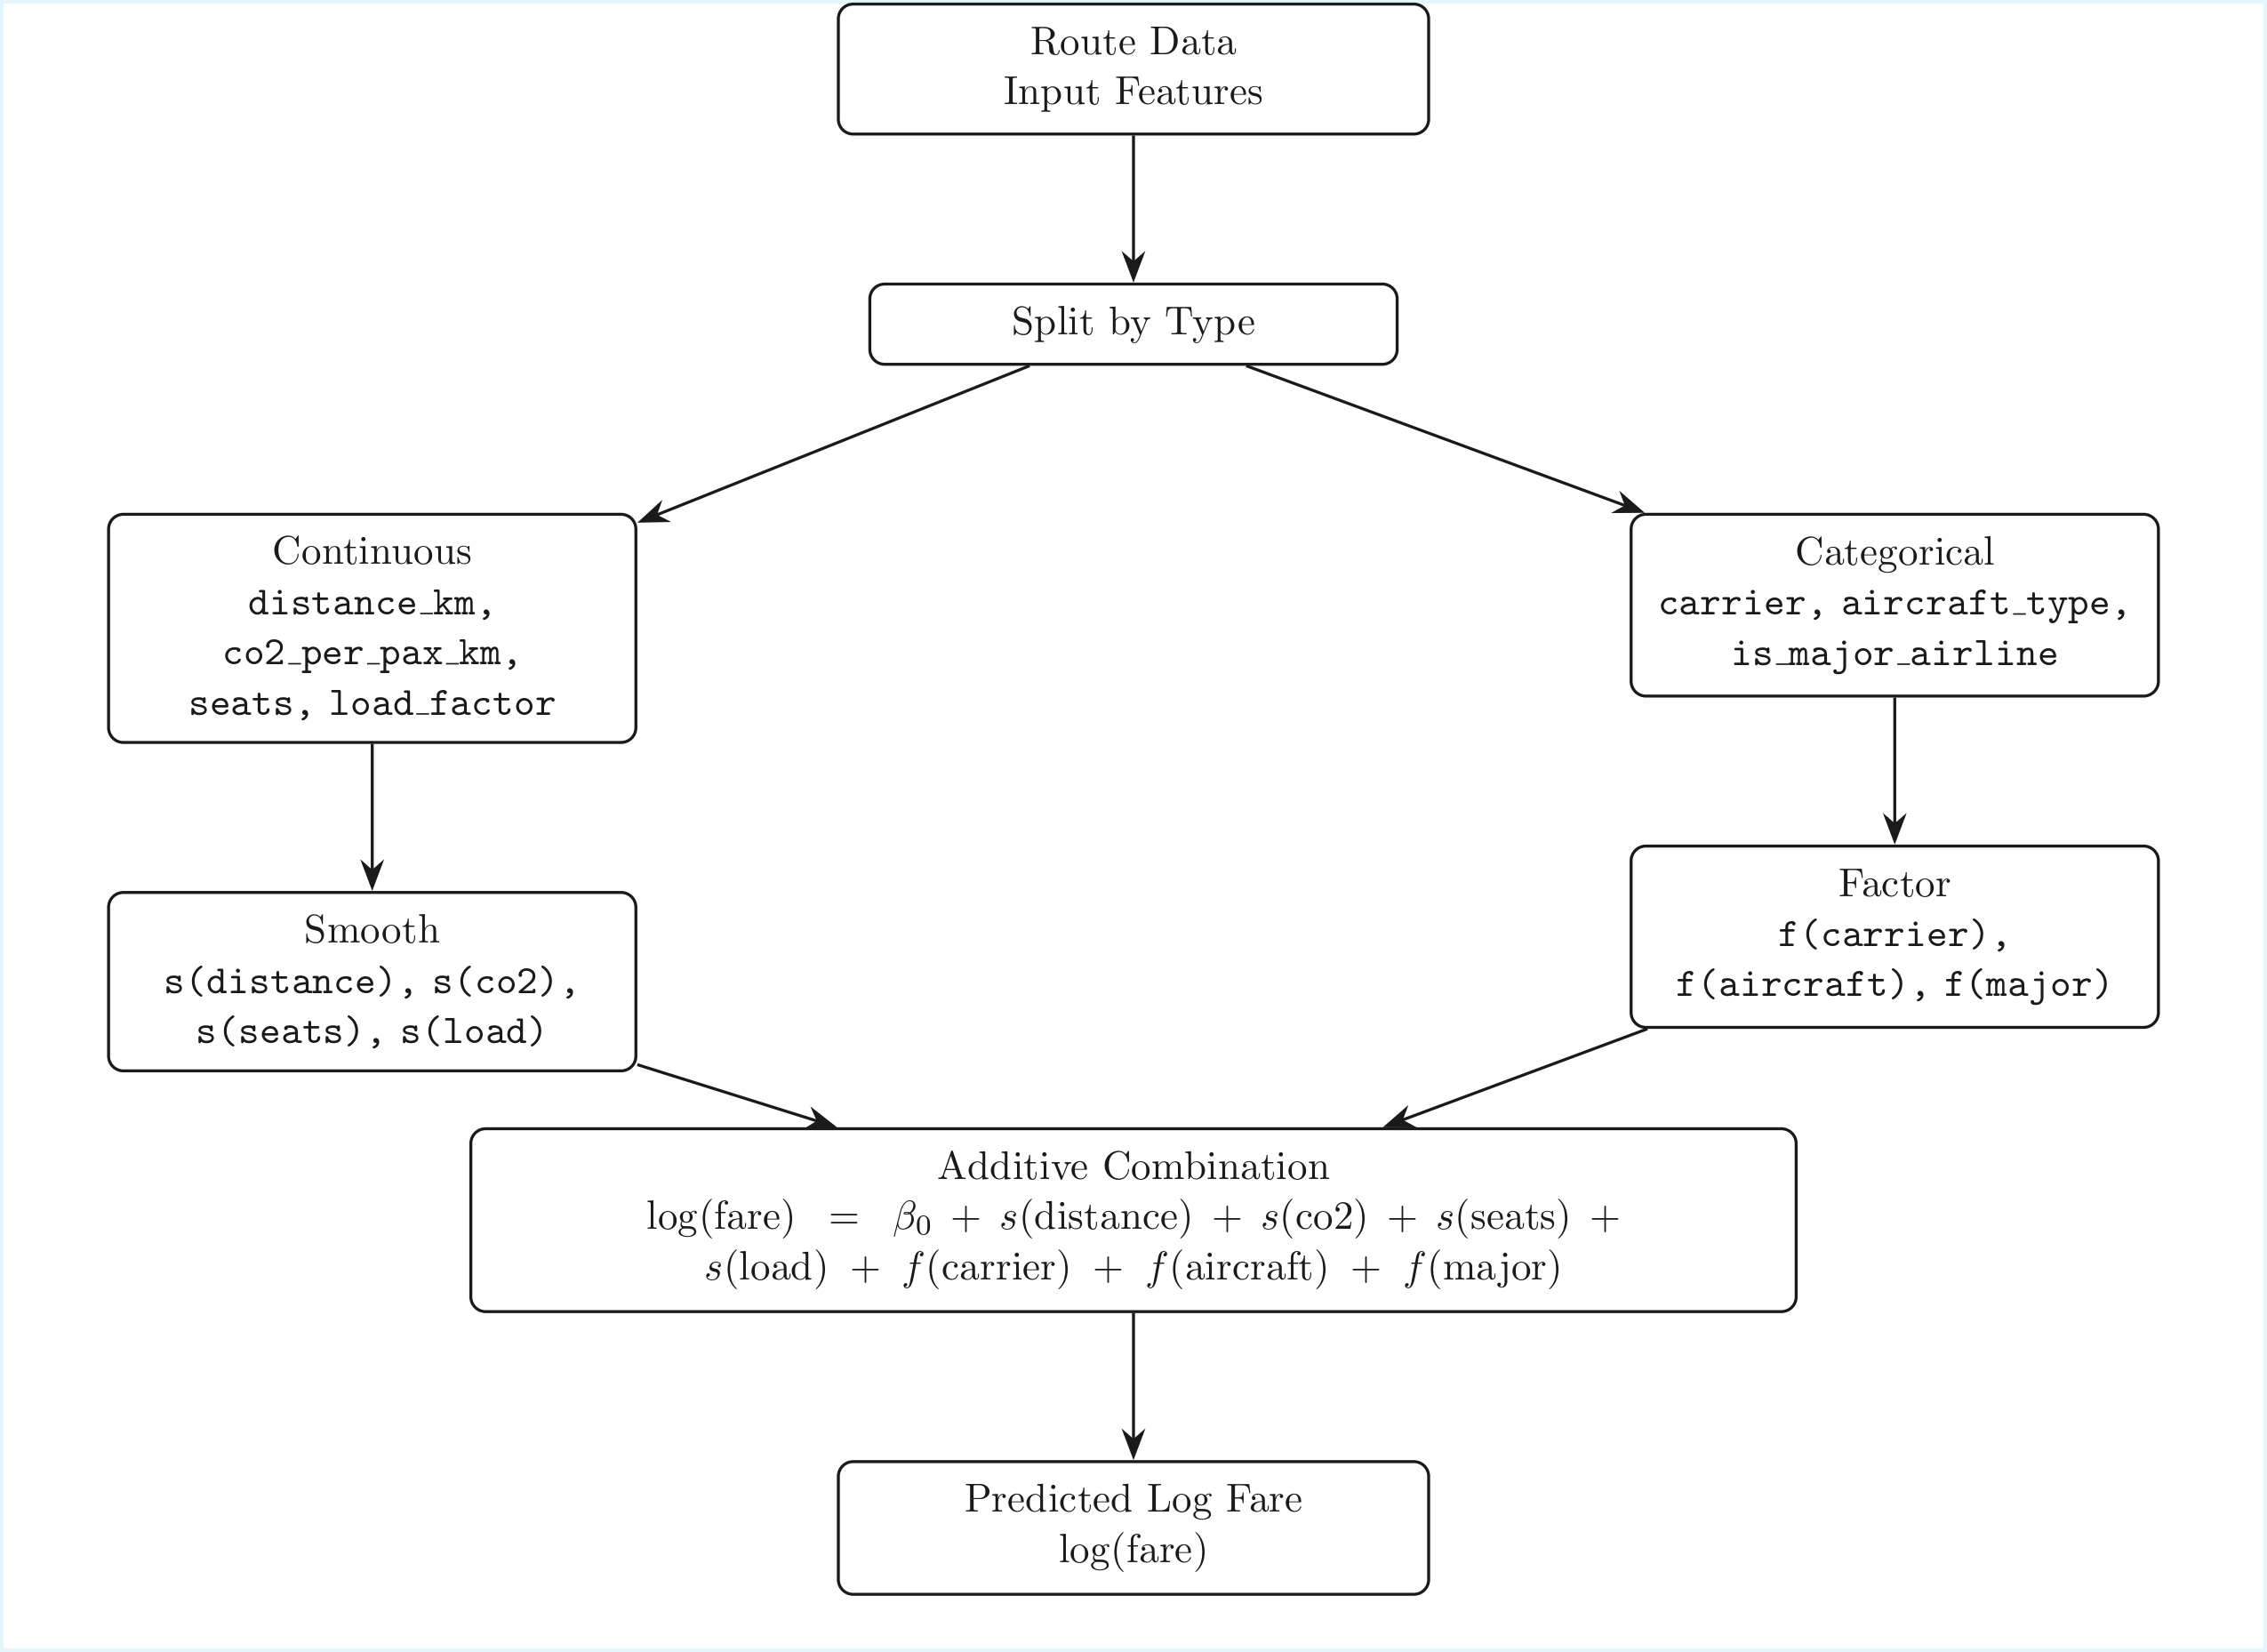

### Additional Imports for GAM

We import PyGAM components to fit our advanced model. The `s()` terms specify smooth effects for continuous variables, while `f()` defines factor (categorical) effects.

In [23]:
from pygam import LinearGAM, s, f

### Model Specification and Data Preparation

The function `prepare_gam_data` filters the dataset to include only observations with positive fares and distances, constructs the log-transformed fare target, and computes the load factor (reported passengers divided by seats). This ensures all continuous variables are in valid ranges and creates the derived operational variable that will be modeled with a smooth function.

In [24]:
def prepare_gam_data(df: pd.DataFrame) -> tuple[pd.DataFrame, pd.Series]:
    df = df.copy()

    # filter for valid fares and distances
    df = df[
        (df["fare"] > 0) &
        (df["distance_km"] > 0)
    ].copy()

    # log transform fare
    df["log_fare"] = np.log(df["fare"])
    # calculate load factor
    df["load_factor"] = df["reported_passengers"] / df["seats"].replace(0, np.nan)

    # ensure log_fare is not NanoN
    valid_idx = df["log_fare"].notna()
    df = df.loc[valid_idx]

    return df, df["log_fare"]


def fit_gam_model(
    df: pd.DataFrame,
    test_size: float = 0.2,
    random_state: int = 1090,
    use_imputation: bool = True
) -> dict:
    df = df.copy()

    # handle co2_per_pax_km missing values
    if use_imputation:
        df = impute_co2_per_pax_km(df)
    else:
        df = df.dropna(subset=["co2_per_pax_km"])

    # prepare data and target
    df_prep, y = prepare_gam_data(df)

    # encode categorical 'carrier' feature
    carrier_cat = pd.Categorical(df_prep["carrier"])
    df_prep["carrier_encoded"] = carrier_cat.codes

    # encode categorical 'aircraft_type' feature
    aircraft_cat = pd.Categorical(df_prep["aircraft_type"])
    df_prep["aircraft_encoded"] = aircraft_cat.codes

    # split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        df_prep, y, test_size=test_size, random_state=random_state
    )

    print(f"Training set size: {len(X_train):,}")
    print(f"Test set size: {len(X_test):,}")

    # get encoded carrier and aircraft type values for train and test sets
    train_carrier_codes = X_train["carrier_encoded"].values
    test_carrier_codes = X_test["carrier_encoded"].values

    train_aircraft_codes = X_train["aircraft_encoded"].values
    test_aircraft_codes = X_test["aircraft_encoded"].values

    # handle unseen carrier codes in the test set
    unseen_carrier_mask = ~np.isin(test_carrier_codes, np.unique(train_carrier_codes))
    if unseen_carrier_mask.sum() > 0:
        most_common_train = pd.Series(train_carrier_codes).mode()[0]
        test_carrier_codes[unseen_carrier_mask] = most_common_train
        print(f"Warning: {unseen_carrier_mask.sum()} test observations with unseen carriers mapped to most common carrier code")

    # handle unseen aircraft type codes in the test set
    unseen_aircraft_mask = ~np.isin(test_aircraft_codes, np.unique(train_aircraft_codes))
    if unseen_aircraft_mask.sum() > 0:
        most_common_train_aircraft = pd.Series(train_aircraft_codes).mode()[0]
        test_aircraft_codes[unseen_aircraft_mask] = most_common_train_aircraft
        print(f"Warning: {unseen_aircraft_mask.sum()} test observations with unseen aircraft types mapped to most common aircraft code")

    # initialize the linear gam model with smooth and factor terms
    gam = LinearGAM(
        s(0, n_splines=10) +
        s(1, n_splines=8) +
        s(2, n_splines=8) +
        s(3, n_splines=8) +
        f(4) +
        f(5) +
        f(6),
        fit_intercept=True
    )

    # prepare the feature matrix for gam training
    X_train_gam = np.column_stack([
        X_train["distance_km"].values,
        X_train["co2_per_pax_km"].values,
        X_train["seats"].values,
        X_train["load_factor"].fillna(X_train["load_factor"].median()).values,
        train_carrier_codes,
        X_train["is_major_airline"].values,
        train_aircraft_codes
    ])

    # prepare the feature matrix for gam testing
    X_test_gam = np.column_stack([
        X_test["distance_km"].values,
        X_test["co2_per_pax_km"].values,
        X_test["seats"].values,
        X_test["load_factor"].fillna(X_train["load_factor"].median()).values,
        test_carrier_codes,
        X_test["is_major_airline"].values,
        test_aircraft_codes
    ])

    print("\nFitting GAM model...")
    # fit the gam model
    gam.fit(X_train_gam, y_train.values)

    # make predictions on train and test sets
    y_train_pred = gam.predict(X_train_gam)
    y_test_pred = gam.predict(X_test_gam)

    # calculate rmse and r2 scores for evaluation
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_r2 = gam.score(X_train_gam, y_train.values)
    test_r2 = gam.score(X_test_gam, y_test.values)

    print(f"\n=== Model Performance ===")
    print(f"Train RMSE (log): {train_rmse:.4f}")
    print(f"Test RMSE (log):  {test_rmse:.4f}")
    print(f"Train R²:         {train_r2:.4f}")
    print(f"Test R²:          {test_r2:.4f}")

    # return results in a dictionary
    return {
        'model': gam,
        'X_train': X_train,
        'X_test': X_test,
        'X_train_gam': X_train_gam,
        'X_test_gam': X_test_gam,
        'y_train': y_train,
        'y_test': y_test,
        'y_train_pred': y_train_pred,
        'y_test_pred': y_test_pred,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'test_r2': test_r2
    }

### Fitting the Model

We fit the GAM model using imputed CO₂-per-passenger values and the same train-test split as the baseline model. The model automatically estimates smooth functions for continuous variables and factor coefficients for categorical variables, then combines them additively to predict log fares.


In [25]:
gam_results = fit_gam_model(merged_df, use_imputation=True) #fitting the model

Imputing 2,076 missing values using prediction-based imputation...
Imputation complete. Mean imputed value: 23.7432
Mean original value: 0.5624
Training set size: 10,804
Test set size: 2,702

Fitting GAM model...

=== Model Performance ===
Train RMSE (log): 0.3565
Test RMSE (log):  0.3431
Train R²:         0.4028
Test R²:          0.4054


### Partial dependence plots

The following code generates partial dependence plots for each smooth term in the GAM. For each continuous variable, we create a grid of values spanning its observed range, hold all other variables at their mean values, and plot how the predicted log fare changes as we vary that single predictor. The plots include 95% confidence intervals (shaded regions) to show uncertainty in the estimated smooth functions. These visualizations reveal the non-linear relationships that the GAM captures, which cannot be represented in the linear baseline model.


Saved plot -> /Users/lennypische/Desktop/docs/OptimalCarbonPricing/images/gam_partial_dependence.png


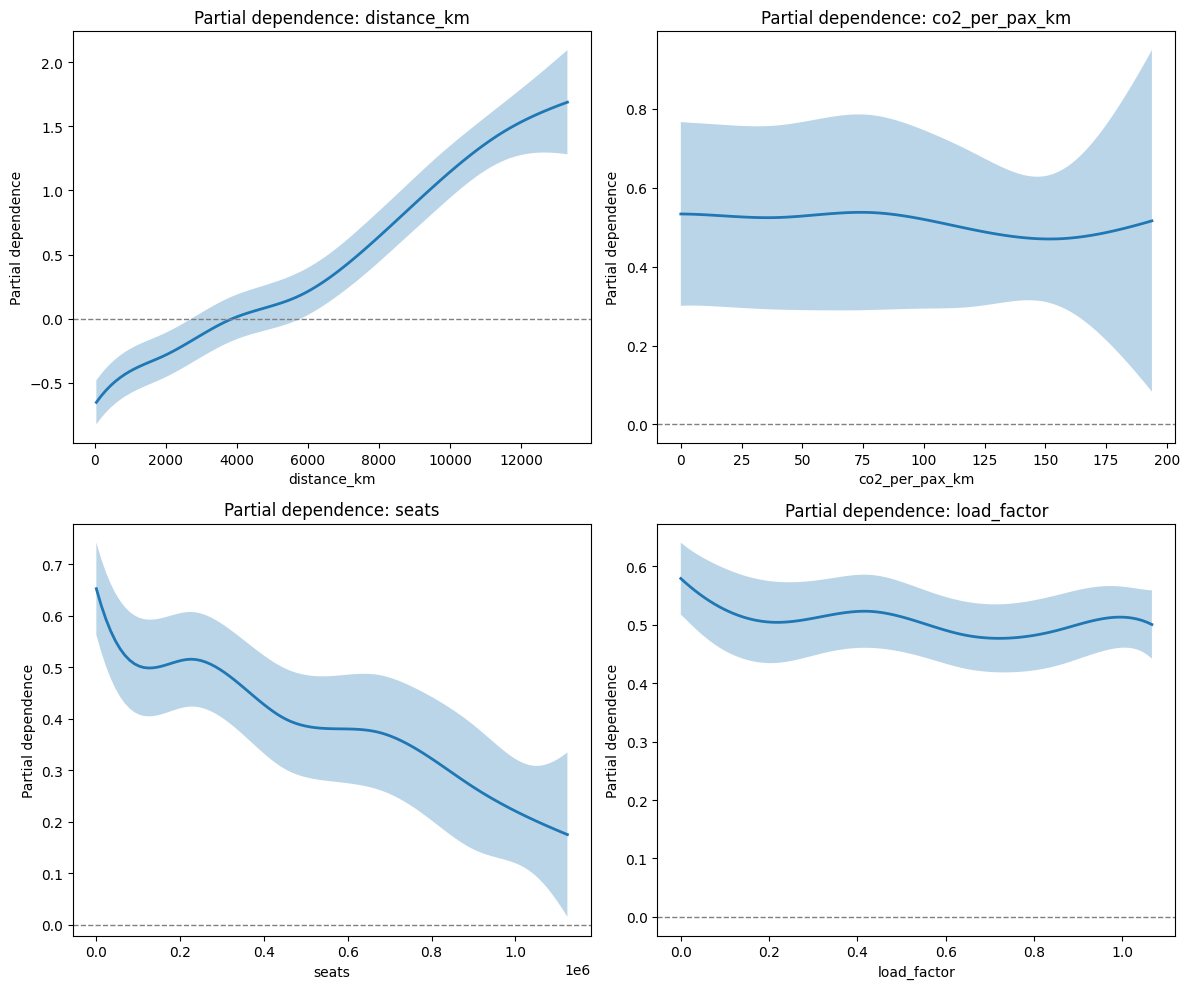

In [26]:
gam = gam_results['model']
X_train_gam = gam_results['X_train_gam']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

feature_names = ['distance_km', 'co2_per_pax_km', 'seats', 'load_factor']
n_points = 100

for i, (ax, name) in enumerate(zip(axes.flat, feature_names)):
    # get min/max values and create a grid for the current feature
    x_min = X_train_gam[:, i].min()
    x_max = X_train_gam[:, i].max()
    x_grid = np.linspace(x_min, x_max, n_points)

    # prepare data for partial dependence calculation
    XX = np.tile(X_train_gam.mean(axis=0), (n_points, 1))
    XX[:, i] = x_grid

    # calculate partial dependence and confidence intervals
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

    # plot the partial dependence and its confidence interval
    ax.plot(x_grid, pdep, linewidth=2)
    ax.fill_between(x_grid, confi[:, 0], confi[:, 1], alpha=0.3)
    ax.axhline(0, color='gray', linestyle='--', linewidth=1)
    ax.set_xlabel(name)
    ax.set_ylabel('Partial dependence')
    ax.set_title(f'Partial dependence: {name}')

plt.tight_layout()
save_and_show(fig, 'gam_partial_dependence')


### Interpretation

The partial dependence plots reveal how each smooth term in the GAM affects log fares while holding all other predictors constant at their average values. These visualizations provide interpretable insights into non-linear pricing relationships that the linear baseline model cannot capture.

- Distance (distance_km): The plot shows a strong, generally increasing relationship, starting at a negative value for very short routes and rising steadily to approximately 1.5 at the maximum distance of around 12,500 km. This pattern is consistent with the baseline model's positive distance elasticity, but the smooth function reveals that the relationship is not perfectly linear in log space. The positive slope reflects that longer routes entail higher absolute costs, though the diminishing rate of increase at very long distances may reflect economies of stage length or market competition effects.

- CO₂ per passenger-km (co2_per_pax_km): The function is relatively flat across most of its range, hovering around 0.5 to 0.6, confirming the baseline model's finding that emissions intensity has minimal direct impact on pricing after controlling for distance, capacity, and carrier effects. The wide confidence interval reflects greater uncertainty, consistent with the small coefficient magnitude (≈ 0.03 elasticity) found in the baseline model. The slight upward trend at very high emissions values (around 200) is accompanied by a substantially wider confidence interval, suggesting this pattern may be driven by extreme observations rather than a systematic pricing relationship. Overall, this flat pattern supports our initial hypothesis that airlines do not systematically price lower-emission flights at a discount.

- Seats: The plot shows a decreasing relationship: fares start at a relatively high value (around 0.65-0.7) for small aircraft and decline to approximately 0.15 for very large aircraft. This pattern suggests that larger aircraft, which typically operate on higher-traffic routes, may benefit from economies of scale that allow for lower per-passenger fares, or reflect market positioning where larger aircraft serve more competitive routes. The confidence interval widens at higher seat counts, reflecting greater uncertainty in regions with fewer observations.

- Load factor: The function exhibits a wavy, non-linear pattern oscillating between approximately 0.4 and 0.6 across the range from 0 to 1.0. This undulating shape suggests complex relationships between capacity utilization and pricing that cannot be represented by a simple linear or log-linear function. The pattern may reflect how airlines adjust pricing strategies based on demand: at very low load factors, airlines may price higher to compensate for low utilization, while at moderate load factors (around 0.4-0.5), pricing may be optimized for revenue management.



## 7. Interpretation and Results <a id="int"></a>

This analysis examined the relationship between airfare pricing and carbon intensity in U.S. domestic aviation using route-level data from 2025. We built three models: a baseline log-log regression with fixed effects, a gradient boosted decision tree (GBDT) model, and a Generalized Additive Model (GAM). The GBDT model improves on the baseline, with a 19% reduction in test RMSE and a 39% increase in R², explaining about 60% of fare variation.

## Key Research Findings

### 1. Carbon Emissions and Pricing

Our initial hypothesis posited that airlines, in their efforts to be environmentally conscious, would price lower-emission flights at a discount. This hypothesis is driven by several factors: airlines' increasing public commitments to sustainability, the operational cost advantages of newer, more efficient aircraft that could be passed through as lower fares, and potential consumer demand for environmentally friendly travel options that might incentivize competitive pricing on low-emission routes.

However, the data reveals **essentially no relationship** between CO₂ intensity and fares after controlling for distance and other factors. In the baseline model, the coefficient on CO₂ per passenger-kilometer is statistically significant but economically negligible (approximately 0.05 elasticity), suggesting that emissions intensity has minimal impact on pricing decisions. Several factors appear to be working against the hypothesis:

- **Operational inefficiencies**: Older aircraft, lower load factors, or less efficient routing that increase both emissions and operational costs, creating a weak positive association that counteracts environmental pricing incentives
- **Market structure**: Routes with varying emissions levels may have different competitive dynamics, with pricing driven more by market power than environmental considerations
- **Route characteristics**: Short-haul routes with high per-kilometer emissions often serve premium markets (e.g., business routes) with inelastic demand, where environmental factors take a backseat to other pricing drivers

The weak relationship indicates that emissions intensity is not a meaningful driver of pricing, suggesting that environmental considerations are not systematically reflected in fare structures.

### 2. Distance as the Primary Driver

Distance emerges as the strongest predictor of airfares. The baseline model shows a distance elasticity of approximately 0.25, meaning a 1% increase in route distance corresponds to roughly a 0.25% increase in fare. This sub-unitary elasticity reflects economies of stage length: longer routes have higher absolute costs but lower per-kilometer costs. The GBDT model confirms this, with distance-related features (including distance squared and distance-emissions interactions) ranking among the most important predictors.

### 3. Model Performance and Improvements

The baseline log-log regression achieves an R² of 0.43 and a test RMSE of 0.3478 in log space, indicating that distance, emissions, carrier fixed effects, and aircraft fixed effects explain a substantial portion of fare variation. The model generalizes well, with similar performance on training and test sets, suggesting limited overfitting despite the large number of fixed effects.

The advanced GBDT model demonstrates substantial improvements over the baseline:

- **Test RMSE reduced from 0.3478 to 0.2812** (19.1% improvement)
- **Test R² increased from 0.431 to 0.600** (39.3% improvement)
- **Residuals are centered around zero** (mean: -0.0056) with no systematic bias
- **Only 3.7% of test observations are outliers** (>2 standard deviations)

These improvements stem from the model's ability to capture non-linear relationships and complex interactions that the linear baseline cannot. For example, the model learns that the relationship between distance and fare varies by emissions level, and that passenger load factors interact with aircraft type in complex ways.

### 4. Feature Importance and Model Insights

The GBDT model's feature importance analysis reveals that distance-related features (raw distance, distance squared, distance-emissions interactions) dominate predictions, followed by passenger load metrics (passengers, reported passengers, load factor) and emissions variables (CO₂ per passenger-km, CO₂ per seat-km). Carrier and aircraft type remain important but are less dominant than in the baseline, as the model captures their effects through interactions with other features.

### 5. Handling Missing Data

A key improvement in the advanced model is the use of prediction-based imputation for the 2,076 missing values in CO₂ per passenger-kilometer (15% of observations). Rather than dropping these observations, we trained a Random Forest model to predict missing emissions values based on distance, aircraft characteristics, payload, and other operational variables. This approach preserves all observations while maintaining the relationship structure in the data, contributing to the model's improved performance.

### Final Model Comparison

In the following code, we produce a last comparison between the models evaluated in this notebook, and provide a final evaluation of model fit.

In [27]:
# =========================
# Baseline (Ridge log–log)
# =========================
y_train_pred_baseline = baseline_model.predict(X_train)
y_test_pred_baseline  = baseline_model.predict(X_test)

baseline_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_baseline))
baseline_test_rmse  = np.sqrt(mean_squared_error(y_test,  y_test_pred_baseline))
baseline_train_r2   = r2_score(y_train, y_train_pred_baseline)
baseline_test_r2    = r2_score(y_test,  y_test_pred_baseline)


# =========================
# GAM model
# (from fit_gam_model)
# =========================
gam_train_rmse = gam_results['train_rmse']
gam_test_rmse  = gam_results['test_rmse']
gam_train_r2   = gam_results['train_r2']
gam_test_r2    = gam_results['test_r2']

# =========================
# Advanced GBDT model
# (from fit_advanced_gbdt_model)
# =========================
gbdt_train_rmse = results['train_rmse']
gbdt_test_rmse  = results['test_rmse']
gbdt_train_r2   = results['train_r2']
gbdt_test_r2    = results['test_r2']

# =========================
# Comparison table
# =========================
comparison_data = {
    'Metric': [
        'Train RMSE (log)',
        'Test RMSE (log)',
        'Train R²',
        'Test R²'
    ],
    'Baseline (Ridge log–log)': [
        f'{baseline_train_rmse:.4f}',
        f'{baseline_test_rmse:.4f}',
        f'{baseline_train_r2:.4f}',
        f'{baseline_test_r2:.4f}',
    ],
    'Advanced (GBDT)': [
        f'{gbdt_train_rmse:.4f}',
        f'{gbdt_test_rmse:.4f}',
        f'{gbdt_train_r2:.4f}',
        f'{gbdt_test_r2:.4f}'
    ],
    'GAM': [
        f'{gam_train_rmse:.4f}',
        f'{gam_test_rmse:.4f}',
        f'{gam_train_r2:.4f}',
        f'{gam_test_r2:.4f}'
    ]
}

comparison_df = pd.DataFrame(comparison_data)
display(comparison_df)

,Metric,Baseline (Ridge log–log),Advanced (GBDT),GAM
0,Train RMSE (log),0.3405,0.1441,0.3565
1,Test RMSE (log),0.3477,0.2812,0.3431
2,Train R²,0.4310,0.9025,0.4028
3,Test R²,0.3778,0.6004,0.4054


### 6. Interpretation of Model Comparison

The table produced by the above code compares the predictive performance of the regularized log–log baseline, the gradient-boosted decision tree (GBDT), and the generalized additive model (GAM). Several clear patterns emerge.

- First, as noted previously, the GBDT model substantially outperforms both parametric and semi-parametric alternatives in terms of predictive accuracy. It achieves a test log-RMSE of $0.28$ and a test $R^2$ of $0.60$, representing a large improvement over the ridge-regularized log–log baseline.

- Second, the GBDT exhibits some degree of overfitting, as evidenced by the large gap between training metrics ($log\text{ }RMSE = 0.14$, $R^2 = 0.90$) and test metrics. However, despite this gap, the model still generalizes substantially better than the baseline, which highlights how the additional structure captured by the boosted trees reflects genuine pricing patterns rather than pure noise.

- Third, despite being an advanced model, the GAM offers only modest improvements over the linear benchmark. While its $test\text{ } RMSE = 0.34$) and $test\text{ }R^2 =0.41$ slightly exceed those of the baseline model, the gains are limited. This suggests that smooth nonlinear effects in individual variables alone are insufficient to capture the complexity of airline pricing without modeling higher-order interactions.

Overall, these results highlight a clear trade-off between interpretability and predictive performance. The regularized log–log model provides a transparent and stable benchmark with economically interpretable elasticities, the GAM introduces limited flexibility through smooth nonlinearities, and the GBDT delivers substantially higher predictive accuracy by exploiting nonlinear interactions and heterogeneous pricing behavior across routes, carriers, and operational characteristics, exactly what GBDT models are designed for.